# DogFaceNet version 4
I hope this one gonna work...

### Imports and constants

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf

import os
import numpy as np
import skimage as sk
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

In [2]:
PATH = '../data/dogfacenet/aligned/after/'
SIZE = (104,104,3)
VALID_SPLIT = 0.1
TEST_SPLIT = 0.05

### Data pre-processing
- Load image and labels
- Training set, validation set (close-set) and testing (open-set)

In [3]:
filenames = np.empty(0)
labels = np.empty(0)
idx = 0
for root,dirs,files in os.walk(PATH):
    if len(files)>1:
        for i in range(len(files)):
            files[i] = root + '/' + files[i]
        filenames = np.append(filenames,files)
        labels = np.append(labels,np.ones(len(files))*idx)
        idx += 1
print(len(labels))
h,w,c = SIZE
images = np.empty((len(filenames),h,w,c))
for i,f in enumerate(filenames):
    images[i] = sk.io.imread(f)

991


In [4]:
# Normalization
#images /= 255.0
images -= 127.5
images /= 128.0


In [5]:
nbof_classes = len(np.unique(labels))

Open-set: test set

In [6]:
nbof_test = int(TEST_SPLIT*nbof_classes)

keep_test = np.less(labels,nbof_test)
keep_train = np.logical_not(keep_test)

images_test = images[keep_test]
labels_test = labels[keep_test]

images_train_tmp = images[keep_train]
labels_train_tmp = labels[keep_train]

Closed-set: validation images

In [7]:
labels_train_tmp -= min(labels_train_tmp)
unique = np.unique(labels_train_tmp)


# Compute number of validation images
nbof_valid = 0
for clas in unique:
    labels_class = labels_train_tmp[np.equal(labels_train_tmp,clas)]
    
    nbof_valid += np.ceil(len(labels_class)*VALID_SPLIT)

nbof_valid = int(nbof_valid)
print("Number of validation images: " + str(nbof_valid))

# Fill the arrays
h,w,c = SIZE
images_train = np.empty((len(images_train_tmp)-nbof_valid,h,w,c))
labels_train = np.empty(len(images_train_tmp)-nbof_valid)

images_valid = np.empty((nbof_valid,h,w,c))
labels_valid = np.empty(nbof_valid)

crt_index_valid = 0
crt_index_train = 0

for clas in unique:
    images_class = images_train_tmp[np.equal(labels_train_tmp,clas)]
    labels_class = labels_train_tmp[np.equal(labels_train_tmp,clas)]
    
    nbof_valid_class = int(np.ceil(len(labels_class)*VALID_SPLIT))
    images_valid[crt_index_valid:crt_index_valid+nbof_valid_class] = images_class[:nbof_valid_class]
    labels_valid[crt_index_valid:crt_index_valid+nbof_valid_class] = labels_class[:nbof_valid_class]
    
    crt_index_valid = crt_index_valid+nbof_valid_class
    
    images_train[crt_index_train:crt_index_train+len(labels_class)-nbof_valid_class] = images_class[nbof_valid_class:]
    labels_train[crt_index_train:crt_index_train+len(labels_class)-nbof_valid_class] = labels_class[nbof_valid_class:]
    
    crt_index_train = crt_index_train+len(labels_class)-nbof_valid_class

Number of validation images: 138


In [8]:
labels_train = tf.keras.utils.to_categorical(labels_train, num_classes=len(unique))
labels_valid = tf.keras.utils.to_categorical(labels_valid, num_classes=len(unique))

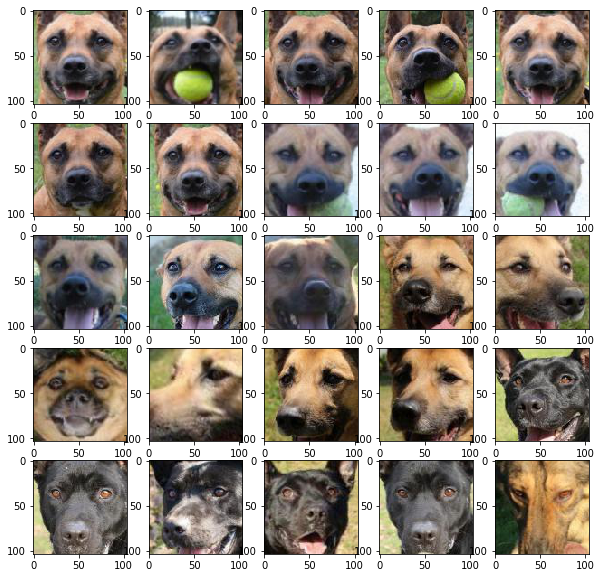

In [9]:
# Test
fig = plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(images_train[i]*0.5+0.5)
    #print(np.argmax(labels_train[i]))

### Loss and Model definition
- Simple model for testing

In [10]:
from tensorflow.keras import backend as K

m = 0.5
s = 64.
out_num = len(unique)

print("Number of outputs: " + str(out_num))

def cosineLoss(y_true,y_pred):
    # Compute the softmax like 
    s_cos = tf.multiply(y_pred, s)
    s_cos_m = tf.add(s_cos, -m)
    exp_s_cos = K.exp(s_cos)
    exp_s_cos_m = K.exp(s_cos_m)
    
    mask = tf.cast(y_true, tf.float32)
    m_mask = tf.multiply(mask,m)
    s_cos_m_mask = tf.subtract(s_cos, m_mask)
    den = K.sum(s_cos_m_mask,1)
    den_stacked = K.stack([den]*out_num,axis=-1)
    
    out = tf.divide(exp_s_cos_m,den_stacked)
    # Compute the categorical crossentropy
    return K.categorical_crossentropy(y_true,out)

Number of outputs: 125


In [26]:
def net(input_shape, emb_size=4):
    input_image = tf.keras.Input(input_shape,name='image_input')
    
    x = tf.keras.layers.Conv2D(32, (3,3), padding='same')(input_image)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Concatenate()([input_image]*11 + [x])
    
    x = tf.keras.layers.MaxPooling2D((3,3))(x)
    
    im = tf.keras.layers.MaxPooling2D((3,3))(input_image)
    
    r = tf.keras.layers.Dropout(0.25)(x)
    
    x = tf.keras.layers.Conv2D(128, (3,3), padding='same')(r)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Concatenate()([im]*21 + [r,x])
    
    x = tf.keras.layers.MaxPooling2D((3,3))(x)
    
    im = tf.keras.layers.MaxPooling2D((3,3))(im)
    
    r = tf.keras.layers.Dropout(0.25)(x)
    
    x = tf.keras.layers.Conv2D(256, (3,3), padding='same')(r)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    x = tf.keras.layers.Concatenate()([r,x])
    
    x = tf.keras.layers.MaxPooling2D((3,3))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
#     emb = tf.keras.layers.Dense(10, activity_regularizer='l2')(x)
#     out = tf.keras.layers.Dense(out_num, kernel_regularizer='l2', use_bias=False, name='output')(emb)
    
    out = tf.keras.layers.Dense(out_num, activation='softmax', name='output')(x)
    
    model = tf.keras.Model(inputs=[input_image], outputs=out)
    return model

w, h, c = SIZE
input_shape = (w, h, c,)
model = net(input_shape)
model.compile(tf.keras.optimizers.Adam(),loss={'output':'categorical_crossentropy'},metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 104, 104, 3)  0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 104, 104, 32) 896         image_input[0][0]                
__________________________________________________________________________________________________
batch_normalization_17 (BatchNo (None, 104, 104, 32) 128         conv2d_24[0][0]                  
__________________________________________________________________________________________________
activation_17 (Activation)      (None, 104, 104, 32) 0           batch_normalization_17[0][0]     
__________________________________________________________________________________________________
concatenat

__________________________________________________________________________________________________
output (Dense)                  (None, 125)          64125       dropout_19[0][0]                 
Total params: 3,091,581
Trainable params: 3,090,749
Non-trainable params: 832
__________________________________________________________________________________________________


### Train it

In [28]:
model.fit(
    images_train,
    labels_train,
    batch_size = 32,
    epochs = 1000,
    validation_data=(images_valid,labels_valid)
)

Train on 814 samples, validate on 138 samples
Epoch 1/1000
814/814 [==============================] - ETA: 2s - loss: 3.5920 - acc: 0.125 - ETA: 2s - loss: 3.6055 - acc: 0.109 - ETA: 2s - loss: 3.4315 - acc: 0.145 - ETA: 2s - loss: 3.5484 - acc: 0.132 - ETA: 2s - loss: 3.6508 - acc: 0.106 - ETA: 1s - loss: 3.6656 - acc: 0.099 - ETA: 1s - loss: 3.6793 - acc: 0.098 - ETA: 1s - loss: 3.6427 - acc: 0.105 - ETA: 1s - loss: 3.6489 - acc: 0.107 - ETA: 1s - loss: 3.6692 - acc: 0.103 - ETA: 1s - loss: 3.6589 - acc: 0.099 - ETA: 1s - loss: 3.6721 - acc: 0.093 - ETA: 1s - loss: 3.7074 - acc: 0.088 - ETA: 1s - loss: 3.6973 - acc: 0.089 - ETA: 1s - loss: 3.6995 - acc: 0.087 - ETA: 0s - loss: 3.6791 - acc: 0.097 - ETA: 0s - loss: 3.6825 - acc: 0.102 - ETA: 0s - loss: 3.6845 - acc: 0.100 - ETA: 0s - loss: 3.6928 - acc: 0.102 - ETA: 0s - loss: 3.6852 - acc: 0.101 - ETA: 0s - loss: 3.6950 - acc: 0.102 - ETA: 0s - loss: 3.6839 - acc: 0.105 - ETA: 0s - loss: 3.6836 - acc: 0.101 - ETA: 0s - loss: 3.6939 -

814/814 [==============================] - ETA: 2s - loss: 3.4630 - acc: 0.187 - ETA: 2s - loss: 3.5279 - acc: 0.171 - ETA: 2s - loss: 3.6939 - acc: 0.156 - ETA: 2s - loss: 3.7046 - acc: 0.140 - ETA: 2s - loss: 3.6732 - acc: 0.131 - ETA: 2s - loss: 3.6251 - acc: 0.140 - ETA: 1s - loss: 3.6181 - acc: 0.133 - ETA: 1s - loss: 3.6033 - acc: 0.140 - ETA: 1s - loss: 3.6262 - acc: 0.128 - ETA: 1s - loss: 3.6244 - acc: 0.131 - ETA: 1s - loss: 3.6089 - acc: 0.139 - ETA: 1s - loss: 3.6338 - acc: 0.132 - ETA: 1s - loss: 3.6533 - acc: 0.127 - ETA: 1s - loss: 3.6460 - acc: 0.133 - ETA: 1s - loss: 3.6207 - acc: 0.139 - ETA: 0s - loss: 3.6094 - acc: 0.140 - ETA: 0s - loss: 3.6013 - acc: 0.137 - ETA: 0s - loss: 3.6004 - acc: 0.135 - ETA: 0s - loss: 3.6097 - acc: 0.136 - ETA: 0s - loss: 3.6069 - acc: 0.131 - ETA: 0s - loss: 3.5958 - acc: 0.132 - ETA: 0s - loss: 3.6048 - acc: 0.130 - ETA: 0s - loss: 3.5948 - acc: 0.129 - ETA: 0s - loss: 3.5944 - acc: 0.126 - ETA: 0s - loss: 3.6127 - acc: 0.125 - 3s 3ms/

814/814 [==============================] - ETA: 2s - loss: 3.6988 - acc: 0.0000e+0 - ETA: 2s - loss: 3.5708 - acc: 0.0781    - ETA: 2s - loss: 3.5891 - acc: 0.083 - ETA: 2s - loss: 3.5721 - acc: 0.085 - ETA: 2s - loss: 3.5549 - acc: 0.093 - ETA: 1s - loss: 3.5542 - acc: 0.099 - ETA: 1s - loss: 3.5423 - acc: 0.107 - ETA: 1s - loss: 3.5413 - acc: 0.101 - ETA: 1s - loss: 3.5403 - acc: 0.100 - ETA: 1s - loss: 3.5452 - acc: 0.106 - ETA: 1s - loss: 3.5243 - acc: 0.108 - ETA: 1s - loss: 3.5106 - acc: 0.104 - ETA: 1s - loss: 3.5318 - acc: 0.103 - ETA: 1s - loss: 3.5434 - acc: 0.107 - ETA: 1s - loss: 3.5527 - acc: 0.106 - ETA: 0s - loss: 3.5255 - acc: 0.111 - ETA: 0s - loss: 3.5336 - acc: 0.110 - ETA: 0s - loss: 3.5160 - acc: 0.116 - ETA: 0s - loss: 3.5266 - acc: 0.111 - ETA: 0s - loss: 3.5262 - acc: 0.109 - ETA: 0s - loss: 3.5273 - acc: 0.110 - ETA: 0s - loss: 3.5363 - acc: 0.109 - ETA: 0s - loss: 3.5370 - acc: 0.110 - ETA: 0s - loss: 3.5362 - acc: 0.112 - ETA: 0s - loss: 3.5556 - acc: 0.110 -

814/814 [==============================] - ETA: 2s - loss: 3.4270 - acc: 0.062 - ETA: 2s - loss: 3.3311 - acc: 0.109 - ETA: 2s - loss: 3.4162 - acc: 0.093 - ETA: 2s - loss: 3.3551 - acc: 0.132 - ETA: 2s - loss: 3.3435 - acc: 0.143 - ETA: 1s - loss: 3.3655 - acc: 0.151 - ETA: 1s - loss: 3.4343 - acc: 0.147 - ETA: 1s - loss: 3.4376 - acc: 0.156 - ETA: 1s - loss: 3.4747 - acc: 0.149 - ETA: 1s - loss: 3.4513 - acc: 0.153 - ETA: 1s - loss: 3.4763 - acc: 0.144 - ETA: 1s - loss: 3.4917 - acc: 0.132 - ETA: 1s - loss: 3.5099 - acc: 0.127 - ETA: 1s - loss: 3.5117 - acc: 0.129 - ETA: 1s - loss: 3.5093 - acc: 0.131 - ETA: 0s - loss: 3.5202 - acc: 0.125 - ETA: 0s - loss: 3.5234 - acc: 0.121 - ETA: 0s - loss: 3.5056 - acc: 0.123 - ETA: 0s - loss: 3.4943 - acc: 0.125 - ETA: 0s - loss: 3.5037 - acc: 0.123 - ETA: 0s - loss: 3.4864 - acc: 0.126 - ETA: 0s - loss: 3.4799 - acc: 0.126 - ETA: 0s - loss: 3.5060 - acc: 0.125 - ETA: 0s - loss: 3.5137 - acc: 0.125 - ETA: 0s - loss: 3.5116 - acc: 0.126 - 3s 3ms/

814/814 [==============================] - ETA: 2s - loss: 3.1262 - acc: 0.187 - ETA: 2s - loss: 3.3602 - acc: 0.125 - ETA: 2s - loss: 3.4821 - acc: 0.104 - ETA: 2s - loss: 3.3666 - acc: 0.109 - ETA: 2s - loss: 3.3579 - acc: 0.118 - ETA: 1s - loss: 3.3860 - acc: 0.109 - ETA: 1s - loss: 3.3507 - acc: 0.120 - ETA: 1s - loss: 3.3780 - acc: 0.113 - ETA: 1s - loss: 3.3904 - acc: 0.114 - ETA: 1s - loss: 3.3843 - acc: 0.118 - ETA: 1s - loss: 3.3959 - acc: 0.119 - ETA: 1s - loss: 3.4066 - acc: 0.125 - ETA: 1s - loss: 3.4042 - acc: 0.127 - ETA: 1s - loss: 3.3983 - acc: 0.129 - ETA: 1s - loss: 3.3873 - acc: 0.127 - ETA: 0s - loss: 3.3855 - acc: 0.127 - ETA: 0s - loss: 3.3993 - acc: 0.123 - ETA: 0s - loss: 3.4248 - acc: 0.116 - ETA: 0s - loss: 3.4140 - acc: 0.113 - ETA: 0s - loss: 3.4112 - acc: 0.114 - ETA: 0s - loss: 3.4183 - acc: 0.113 - ETA: 0s - loss: 3.4305 - acc: 0.109 - ETA: 0s - loss: 3.4452 - acc: 0.106 - ETA: 0s - loss: 3.4479 - acc: 0.108 - ETA: 0s - loss: 3.4547 - acc: 0.105 - 3s 3ms/

814/814 [==============================] - ETA: 2s - loss: 3.3180 - acc: 0.156 - ETA: 2s - loss: 3.4892 - acc: 0.125 - ETA: 2s - loss: 3.4882 - acc: 0.104 - ETA: 2s - loss: 3.5582 - acc: 0.085 - ETA: 2s - loss: 3.4285 - acc: 0.100 - ETA: 2s - loss: 3.4649 - acc: 0.093 - ETA: 1s - loss: 3.4159 - acc: 0.089 - ETA: 1s - loss: 3.4331 - acc: 0.085 - ETA: 1s - loss: 3.4498 - acc: 0.090 - ETA: 1s - loss: 3.4720 - acc: 0.093 - ETA: 1s - loss: 3.4599 - acc: 0.102 - ETA: 1s - loss: 3.4652 - acc: 0.109 - ETA: 1s - loss: 3.4753 - acc: 0.103 - ETA: 1s - loss: 3.4742 - acc: 0.102 - ETA: 1s - loss: 3.4860 - acc: 0.100 - ETA: 0s - loss: 3.4954 - acc: 0.101 - ETA: 0s - loss: 3.5108 - acc: 0.099 - ETA: 0s - loss: 3.5015 - acc: 0.104 - ETA: 0s - loss: 3.4984 - acc: 0.106 - ETA: 0s - loss: 3.5140 - acc: 0.106 - ETA: 0s - loss: 3.4951 - acc: 0.107 - ETA: 0s - loss: 3.4728 - acc: 0.112 - ETA: 0s - loss: 3.4792 - acc: 0.112 - ETA: 0s - loss: 3.4882 - acc: 0.109 - ETA: 0s - loss: 3.4916 - acc: 0.107 - 3s 4ms/

814/814 [==============================] - ETA: 2s - loss: 3.4103 - acc: 0.062 - ETA: 2s - loss: 3.5316 - acc: 0.046 - ETA: 2s - loss: 3.4897 - acc: 0.052 - ETA: 2s - loss: 3.5313 - acc: 0.046 - ETA: 2s - loss: 3.4425 - acc: 0.087 - ETA: 1s - loss: 3.4497 - acc: 0.099 - ETA: 1s - loss: 3.4309 - acc: 0.093 - ETA: 1s - loss: 3.4593 - acc: 0.093 - ETA: 1s - loss: 3.4350 - acc: 0.093 - ETA: 1s - loss: 3.4228 - acc: 0.096 - ETA: 1s - loss: 3.4217 - acc: 0.096 - ETA: 1s - loss: 3.3892 - acc: 0.106 - ETA: 1s - loss: 3.3905 - acc: 0.105 - ETA: 1s - loss: 3.3965 - acc: 0.102 - ETA: 1s - loss: 3.3994 - acc: 0.106 - ETA: 0s - loss: 3.4135 - acc: 0.107 - ETA: 0s - loss: 3.4012 - acc: 0.110 - ETA: 0s - loss: 3.4097 - acc: 0.109 - ETA: 0s - loss: 3.4169 - acc: 0.108 - ETA: 0s - loss: 3.3999 - acc: 0.109 - ETA: 0s - loss: 3.3782 - acc: 0.114 - ETA: 0s - loss: 3.3899 - acc: 0.110 - ETA: 0s - loss: 3.3957 - acc: 0.110 - ETA: 0s - loss: 3.3969 - acc: 0.112 - ETA: 0s - loss: 3.3884 - acc: 0.115 - 3s 3ms/

814/814 [==============================] - ETA: 2s - loss: 3.6610 - acc: 0.125 - ETA: 2s - loss: 3.5949 - acc: 0.125 - ETA: 2s - loss: 3.4093 - acc: 0.177 - ETA: 2s - loss: 3.3847 - acc: 0.171 - ETA: 2s - loss: 3.3814 - acc: 0.162 - ETA: 1s - loss: 3.3765 - acc: 0.166 - ETA: 1s - loss: 3.3004 - acc: 0.183 - ETA: 1s - loss: 3.2900 - acc: 0.179 - ETA: 1s - loss: 3.2661 - acc: 0.177 - ETA: 1s - loss: 3.2603 - acc: 0.178 - ETA: 1s - loss: 3.3001 - acc: 0.170 - ETA: 1s - loss: 3.3059 - acc: 0.164 - ETA: 1s - loss: 3.2982 - acc: 0.161 - ETA: 1s - loss: 3.3129 - acc: 0.156 - ETA: 1s - loss: 3.3300 - acc: 0.150 - ETA: 0s - loss: 3.3447 - acc: 0.146 - ETA: 0s - loss: 3.3522 - acc: 0.141 - ETA: 0s - loss: 3.3223 - acc: 0.142 - ETA: 0s - loss: 3.3257 - acc: 0.141 - ETA: 0s - loss: 3.3242 - acc: 0.143 - ETA: 0s - loss: 3.3228 - acc: 0.144 - ETA: 0s - loss: 3.3311 - acc: 0.140 - ETA: 0s - loss: 3.3382 - acc: 0.135 - ETA: 0s - loss: 3.3428 - acc: 0.134 - ETA: 0s - loss: 3.3373 - acc: 0.136 - 3s 3ms/

814/814 [==============================] - ETA: 2s - loss: 3.4378 - acc: 0.156 - ETA: 2s - loss: 3.4517 - acc: 0.140 - ETA: 2s - loss: 3.4761 - acc: 0.093 - ETA: 2s - loss: 3.4620 - acc: 0.109 - ETA: 2s - loss: 3.4833 - acc: 0.112 - ETA: 1s - loss: 3.4551 - acc: 0.119 - ETA: 1s - loss: 3.4610 - acc: 0.111 - ETA: 1s - loss: 3.4562 - acc: 0.113 - ETA: 1s - loss: 3.4753 - acc: 0.107 - ETA: 1s - loss: 3.4657 - acc: 0.112 - ETA: 1s - loss: 3.4606 - acc: 0.116 - ETA: 1s - loss: 3.4630 - acc: 0.119 - ETA: 1s - loss: 3.4482 - acc: 0.120 - ETA: 1s - loss: 3.4216 - acc: 0.120 - ETA: 1s - loss: 3.3971 - acc: 0.122 - ETA: 0s - loss: 3.3665 - acc: 0.132 - ETA: 0s - loss: 3.3687 - acc: 0.128 - ETA: 0s - loss: 3.3735 - acc: 0.126 - ETA: 0s - loss: 3.3758 - acc: 0.121 - ETA: 0s - loss: 3.3730 - acc: 0.128 - ETA: 0s - loss: 3.3487 - acc: 0.135 - ETA: 0s - loss: 3.3432 - acc: 0.133 - ETA: 0s - loss: 3.3534 - acc: 0.131 - ETA: 0s - loss: 3.3416 - acc: 0.130 - ETA: 0s - loss: 3.3490 - acc: 0.128 - 3s 3ms/

814/814 [==============================] - ETA: 2s - loss: 3.4119 - acc: 0.031 - ETA: 2s - loss: 3.2330 - acc: 0.062 - ETA: 2s - loss: 3.0627 - acc: 0.125 - ETA: 2s - loss: 3.1225 - acc: 0.125 - ETA: 2s - loss: 3.2355 - acc: 0.118 - ETA: 2s - loss: 3.2648 - acc: 0.125 - ETA: 1s - loss: 3.2253 - acc: 0.133 - ETA: 1s - loss: 3.2950 - acc: 0.132 - ETA: 1s - loss: 3.3003 - acc: 0.128 - ETA: 1s - loss: 3.3032 - acc: 0.131 - ETA: 1s - loss: 3.2887 - acc: 0.127 - ETA: 1s - loss: 3.3137 - acc: 0.125 - ETA: 1s - loss: 3.3094 - acc: 0.120 - ETA: 1s - loss: 3.3184 - acc: 0.122 - ETA: 1s - loss: 3.3189 - acc: 0.129 - ETA: 0s - loss: 3.3348 - acc: 0.127 - ETA: 0s - loss: 3.3299 - acc: 0.132 - ETA: 0s - loss: 3.3286 - acc: 0.130 - ETA: 0s - loss: 3.3157 - acc: 0.129 - ETA: 0s - loss: 3.3242 - acc: 0.128 - ETA: 0s - loss: 3.3291 - acc: 0.129 - ETA: 0s - loss: 3.3211 - acc: 0.130 - ETA: 0s - loss: 3.3077 - acc: 0.133 - ETA: 0s - loss: 3.3153 - acc: 0.131 - ETA: 0s - loss: 3.3189 - acc: 0.130 - 3s 3ms/

814/814 [==============================] - ETA: 2s - loss: 3.2380 - acc: 0.187 - ETA: 2s - loss: 3.2533 - acc: 0.140 - ETA: 2s - loss: 3.2885 - acc: 0.125 - ETA: 2s - loss: 3.1612 - acc: 0.156 - ETA: 2s - loss: 3.2035 - acc: 0.156 - ETA: 2s - loss: 3.1862 - acc: 0.161 - ETA: 2s - loss: 3.2369 - acc: 0.160 - ETA: 1s - loss: 3.2520 - acc: 0.152 - ETA: 1s - loss: 3.2421 - acc: 0.145 - ETA: 1s - loss: 3.2825 - acc: 0.134 - ETA: 1s - loss: 3.2910 - acc: 0.133 - ETA: 1s - loss: 3.3020 - acc: 0.130 - ETA: 1s - loss: 3.3042 - acc: 0.134 - ETA: 1s - loss: 3.3330 - acc: 0.129 - ETA: 1s - loss: 3.3497 - acc: 0.129 - ETA: 1s - loss: 3.3472 - acc: 0.130 - ETA: 0s - loss: 3.3646 - acc: 0.126 - ETA: 0s - loss: 3.3508 - acc: 0.128 - ETA: 0s - loss: 3.3295 - acc: 0.133 - ETA: 0s - loss: 3.3292 - acc: 0.137 - ETA: 0s - loss: 3.3380 - acc: 0.135 - ETA: 0s - loss: 3.3401 - acc: 0.134 - ETA: 0s - loss: 3.3170 - acc: 0.139 - ETA: 0s - loss: 3.3189 - acc: 0.139 - ETA: 0s - loss: 3.3347 - acc: 0.137 - 3s 4ms/

814/814 [==============================] - ETA: 2s - loss: 3.1705 - acc: 0.218 - ETA: 2s - loss: 3.1241 - acc: 0.171 - ETA: 2s - loss: 3.1132 - acc: 0.177 - ETA: 2s - loss: 3.1956 - acc: 0.148 - ETA: 2s - loss: 3.2203 - acc: 0.137 - ETA: 1s - loss: 3.2484 - acc: 0.140 - ETA: 1s - loss: 3.2866 - acc: 0.133 - ETA: 1s - loss: 3.2577 - acc: 0.140 - ETA: 1s - loss: 3.2286 - acc: 0.152 - ETA: 1s - loss: 3.2516 - acc: 0.150 - ETA: 1s - loss: 3.2544 - acc: 0.150 - ETA: 1s - loss: 3.2302 - acc: 0.148 - ETA: 1s - loss: 3.2331 - acc: 0.149 - ETA: 1s - loss: 3.2147 - acc: 0.147 - ETA: 1s - loss: 3.2486 - acc: 0.141 - ETA: 1s - loss: 3.2708 - acc: 0.138 - ETA: 0s - loss: 3.2550 - acc: 0.139 - ETA: 0s - loss: 3.2526 - acc: 0.135 - ETA: 0s - loss: 3.2457 - acc: 0.139 - ETA: 0s - loss: 3.2462 - acc: 0.137 - ETA: 0s - loss: 3.2406 - acc: 0.135 - ETA: 0s - loss: 3.2354 - acc: 0.139 - ETA: 0s - loss: 3.2389 - acc: 0.137 - ETA: 0s - loss: 3.2432 - acc: 0.135 - ETA: 0s - loss: 3.2585 - acc: 0.133 - 3s 3ms/

814/814 [==============================] - ETA: 2s - loss: 3.4550 - acc: 0.187 - ETA: 2s - loss: 3.0702 - acc: 0.234 - ETA: 2s - loss: 3.2064 - acc: 0.177 - ETA: 2s - loss: 3.1924 - acc: 0.179 - ETA: 2s - loss: 3.1260 - acc: 0.200 - ETA: 1s - loss: 3.1770 - acc: 0.177 - ETA: 1s - loss: 3.2033 - acc: 0.165 - ETA: 1s - loss: 3.1686 - acc: 0.164 - ETA: 1s - loss: 3.1914 - acc: 0.159 - ETA: 1s - loss: 3.1790 - acc: 0.168 - ETA: 1s - loss: 3.1621 - acc: 0.167 - ETA: 1s - loss: 3.1664 - acc: 0.164 - ETA: 1s - loss: 3.2008 - acc: 0.156 - ETA: 1s - loss: 3.1852 - acc: 0.158 - ETA: 1s - loss: 3.1931 - acc: 0.158 - ETA: 0s - loss: 3.2047 - acc: 0.154 - ETA: 0s - loss: 3.2130 - acc: 0.148 - ETA: 0s - loss: 3.2378 - acc: 0.147 - ETA: 0s - loss: 3.2447 - acc: 0.143 - ETA: 0s - loss: 3.2366 - acc: 0.143 - ETA: 0s - loss: 3.2588 - acc: 0.141 - ETA: 0s - loss: 3.2629 - acc: 0.143 - ETA: 0s - loss: 3.2706 - acc: 0.142 - ETA: 0s - loss: 3.2632 - acc: 0.141 - ETA: 0s - loss: 3.2560 - acc: 0.141 - 3s 3ms/

814/814 [==============================] - ETA: 2s - loss: 3.1430 - acc: 0.187 - ETA: 2s - loss: 3.2624 - acc: 0.125 - ETA: 2s - loss: 3.2052 - acc: 0.166 - ETA: 2s - loss: 3.2342 - acc: 0.171 - ETA: 2s - loss: 3.1900 - acc: 0.162 - ETA: 2s - loss: 3.1969 - acc: 0.156 - ETA: 1s - loss: 3.1797 - acc: 0.160 - ETA: 1s - loss: 3.2567 - acc: 0.164 - ETA: 1s - loss: 3.2693 - acc: 0.163 - ETA: 1s - loss: 3.2794 - acc: 0.156 - ETA: 1s - loss: 3.2648 - acc: 0.153 - ETA: 1s - loss: 3.2813 - acc: 0.153 - ETA: 1s - loss: 3.2887 - acc: 0.153 - ETA: 1s - loss: 3.2748 - acc: 0.151 - ETA: 1s - loss: 3.2930 - acc: 0.143 - ETA: 1s - loss: 3.2726 - acc: 0.140 - ETA: 0s - loss: 3.2630 - acc: 0.141 - ETA: 0s - loss: 3.2531 - acc: 0.145 - ETA: 0s - loss: 3.2529 - acc: 0.143 - ETA: 0s - loss: 3.2425 - acc: 0.146 - ETA: 0s - loss: 3.2316 - acc: 0.148 - ETA: 0s - loss: 3.2289 - acc: 0.147 - ETA: 0s - loss: 3.2326 - acc: 0.146 - ETA: 0s - loss: 3.2328 - acc: 0.149 - ETA: 0s - loss: 3.2408 - acc: 0.146 - 3s 4ms/

814/814 [==============================] - ETA: 2s - loss: 3.2334 - acc: 0.062 - ETA: 2s - loss: 3.1858 - acc: 0.093 - ETA: 2s - loss: 3.0668 - acc: 0.135 - ETA: 2s - loss: 3.1159 - acc: 0.148 - ETA: 2s - loss: 3.1756 - acc: 0.137 - ETA: 1s - loss: 3.1702 - acc: 0.145 - ETA: 1s - loss: 3.1269 - acc: 0.142 - ETA: 1s - loss: 3.1884 - acc: 0.144 - ETA: 1s - loss: 3.1980 - acc: 0.138 - ETA: 1s - loss: 3.2010 - acc: 0.131 - ETA: 1s - loss: 3.2074 - acc: 0.139 - ETA: 1s - loss: 3.2141 - acc: 0.138 - ETA: 1s - loss: 3.2152 - acc: 0.137 - ETA: 1s - loss: 3.2303 - acc: 0.133 - ETA: 1s - loss: 3.2315 - acc: 0.131 - ETA: 1s - loss: 3.2262 - acc: 0.134 - ETA: 0s - loss: 3.2253 - acc: 0.132 - ETA: 0s - loss: 3.2007 - acc: 0.135 - ETA: 0s - loss: 3.1946 - acc: 0.139 - ETA: 0s - loss: 3.2079 - acc: 0.135 - ETA: 0s - loss: 3.1952 - acc: 0.139 - ETA: 0s - loss: 3.1790 - acc: 0.142 - ETA: 0s - loss: 3.2015 - acc: 0.137 - ETA: 0s - loss: 3.1957 - acc: 0.139 - ETA: 0s - loss: 3.1750 - acc: 0.143 - 3s 4ms/

814/814 [==============================] - ETA: 2s - loss: 3.5489 - acc: 0.156 - ETA: 2s - loss: 3.4180 - acc: 0.156 - ETA: 2s - loss: 3.5114 - acc: 0.125 - ETA: 2s - loss: 3.3528 - acc: 0.156 - ETA: 2s - loss: 3.3752 - acc: 0.143 - ETA: 1s - loss: 3.3663 - acc: 0.140 - ETA: 1s - loss: 3.3268 - acc: 0.147 - ETA: 1s - loss: 3.3513 - acc: 0.148 - ETA: 1s - loss: 3.3019 - acc: 0.159 - ETA: 1s - loss: 3.2775 - acc: 0.156 - ETA: 1s - loss: 3.2817 - acc: 0.144 - ETA: 1s - loss: 3.2752 - acc: 0.151 - ETA: 1s - loss: 3.2284 - acc: 0.146 - ETA: 1s - loss: 3.2387 - acc: 0.145 - ETA: 1s - loss: 3.2184 - acc: 0.150 - ETA: 0s - loss: 3.2390 - acc: 0.148 - ETA: 0s - loss: 3.2407 - acc: 0.145 - ETA: 0s - loss: 3.2334 - acc: 0.147 - ETA: 0s - loss: 3.2395 - acc: 0.146 - ETA: 0s - loss: 3.2407 - acc: 0.148 - ETA: 0s - loss: 3.2383 - acc: 0.145 - ETA: 0s - loss: 3.2289 - acc: 0.149 - ETA: 0s - loss: 3.2190 - acc: 0.150 - ETA: 0s - loss: 3.2163 - acc: 0.145 - ETA: 0s - loss: 3.2046 - acc: 0.147 - 3s 3ms/

814/814 [==============================] - ETA: 2s - loss: 2.8903 - acc: 0.218 - ETA: 2s - loss: 3.2850 - acc: 0.156 - ETA: 2s - loss: 3.2622 - acc: 0.156 - ETA: 2s - loss: 3.2194 - acc: 0.171 - ETA: 2s - loss: 3.2241 - acc: 0.162 - ETA: 1s - loss: 3.1407 - acc: 0.177 - ETA: 1s - loss: 3.1811 - acc: 0.156 - ETA: 1s - loss: 3.1956 - acc: 0.152 - ETA: 1s - loss: 3.1793 - acc: 0.149 - ETA: 1s - loss: 3.1496 - acc: 0.159 - ETA: 1s - loss: 3.1830 - acc: 0.156 - ETA: 1s - loss: 3.2227 - acc: 0.156 - ETA: 1s - loss: 3.2227 - acc: 0.158 - ETA: 1s - loss: 3.2020 - acc: 0.167 - ETA: 1s - loss: 3.1832 - acc: 0.166 - ETA: 0s - loss: 3.2112 - acc: 0.160 - ETA: 0s - loss: 3.2023 - acc: 0.165 - ETA: 0s - loss: 3.2148 - acc: 0.161 - ETA: 0s - loss: 3.2073 - acc: 0.161 - ETA: 0s - loss: 3.2007 - acc: 0.164 - ETA: 0s - loss: 3.2153 - acc: 0.160 - ETA: 0s - loss: 3.2080 - acc: 0.159 - ETA: 0s - loss: 3.1968 - acc: 0.160 - ETA: 0s - loss: 3.1860 - acc: 0.158 - ETA: 0s - loss: 3.1865 - acc: 0.157 - 3s 3ms/

814/814 [==============================] - ETA: 2s - loss: 3.3316 - acc: 0.093 - ETA: 2s - loss: 3.3228 - acc: 0.062 - ETA: 2s - loss: 3.3431 - acc: 0.083 - ETA: 2s - loss: 3.2578 - acc: 0.125 - ETA: 2s - loss: 3.2572 - acc: 0.131 - ETA: 1s - loss: 3.2494 - acc: 0.130 - ETA: 1s - loss: 3.1878 - acc: 0.151 - ETA: 1s - loss: 3.1353 - acc: 0.160 - ETA: 1s - loss: 3.1464 - acc: 0.166 - ETA: 1s - loss: 3.1316 - acc: 0.171 - ETA: 1s - loss: 3.1304 - acc: 0.167 - ETA: 1s - loss: 3.0916 - acc: 0.177 - ETA: 1s - loss: 3.1075 - acc: 0.173 - ETA: 1s - loss: 3.1246 - acc: 0.169 - ETA: 1s - loss: 3.1048 - acc: 0.170 - ETA: 0s - loss: 3.1078 - acc: 0.166 - ETA: 0s - loss: 3.1211 - acc: 0.163 - ETA: 0s - loss: 3.1347 - acc: 0.156 - ETA: 0s - loss: 3.1260 - acc: 0.156 - ETA: 0s - loss: 3.1368 - acc: 0.154 - ETA: 0s - loss: 3.1254 - acc: 0.159 - ETA: 0s - loss: 3.1316 - acc: 0.157 - ETA: 0s - loss: 3.1294 - acc: 0.159 - ETA: 0s - loss: 3.1446 - acc: 0.157 - ETA: 0s - loss: 3.1348 - acc: 0.157 - 3s 3ms/

814/814 [==============================] - ETA: 2s - loss: 3.6096 - acc: 0.031 - ETA: 2s - loss: 3.4422 - acc: 0.109 - ETA: 2s - loss: 3.4902 - acc: 0.093 - ETA: 2s - loss: 3.4726 - acc: 0.093 - ETA: 2s - loss: 3.4305 - acc: 0.093 - ETA: 2s - loss: 3.3246 - acc: 0.109 - ETA: 1s - loss: 3.3282 - acc: 0.107 - ETA: 1s - loss: 3.3054 - acc: 0.105 - ETA: 1s - loss: 3.2857 - acc: 0.107 - ETA: 1s - loss: 3.2810 - acc: 0.100 - ETA: 1s - loss: 3.2194 - acc: 0.108 - ETA: 1s - loss: 3.2104 - acc: 0.109 - ETA: 1s - loss: 3.1944 - acc: 0.117 - ETA: 1s - loss: 3.2245 - acc: 0.116 - ETA: 1s - loss: 3.2286 - acc: 0.118 - ETA: 0s - loss: 3.2390 - acc: 0.121 - ETA: 0s - loss: 3.2410 - acc: 0.119 - ETA: 0s - loss: 3.2448 - acc: 0.118 - ETA: 0s - loss: 3.2597 - acc: 0.115 - ETA: 0s - loss: 3.2586 - acc: 0.117 - ETA: 0s - loss: 3.2545 - acc: 0.114 - ETA: 0s - loss: 3.2647 - acc: 0.110 - ETA: 0s - loss: 3.2674 - acc: 0.111 - ETA: 0s - loss: 3.2773 - acc: 0.109 - ETA: 0s - loss: 3.2865 - acc: 0.108 - 3s 3ms/

814/814 [==============================] - ETA: 2s - loss: 3.3926 - acc: 0.125 - ETA: 2s - loss: 3.1482 - acc: 0.140 - ETA: 2s - loss: 3.3319 - acc: 0.114 - ETA: 2s - loss: 3.3806 - acc: 0.117 - ETA: 2s - loss: 3.3868 - acc: 0.106 - ETA: 2s - loss: 3.3343 - acc: 0.119 - ETA: 1s - loss: 3.3158 - acc: 0.129 - ETA: 1s - loss: 3.3032 - acc: 0.140 - ETA: 1s - loss: 3.2714 - acc: 0.135 - ETA: 1s - loss: 3.2865 - acc: 0.134 - ETA: 1s - loss: 3.2774 - acc: 0.139 - ETA: 1s - loss: 3.2792 - acc: 0.135 - ETA: 1s - loss: 3.2862 - acc: 0.134 - ETA: 1s - loss: 3.2902 - acc: 0.138 - ETA: 1s - loss: 3.2667 - acc: 0.145 - ETA: 0s - loss: 3.2696 - acc: 0.142 - ETA: 0s - loss: 3.2470 - acc: 0.147 - ETA: 0s - loss: 3.2625 - acc: 0.140 - ETA: 0s - loss: 3.2575 - acc: 0.138 - ETA: 0s - loss: 3.2328 - acc: 0.142 - ETA: 0s - loss: 3.2302 - acc: 0.145 - ETA: 0s - loss: 3.2218 - acc: 0.147 - ETA: 0s - loss: 3.2119 - acc: 0.153 - ETA: 0s - loss: 3.2048 - acc: 0.158 - ETA: 0s - loss: 3.2031 - acc: 0.157 - 3s 3ms/

814/814 [==============================] - ETA: 2s - loss: 3.2652 - acc: 0.062 - ETA: 2s - loss: 3.1107 - acc: 0.109 - ETA: 2s - loss: 3.0941 - acc: 0.083 - ETA: 2s - loss: 3.0143 - acc: 0.117 - ETA: 2s - loss: 3.0182 - acc: 0.125 - ETA: 1s - loss: 2.9851 - acc: 0.151 - ETA: 1s - loss: 3.0133 - acc: 0.147 - ETA: 1s - loss: 3.0568 - acc: 0.140 - ETA: 1s - loss: 3.0609 - acc: 0.156 - ETA: 1s - loss: 3.0741 - acc: 0.156 - ETA: 1s - loss: 3.0876 - acc: 0.153 - ETA: 1s - loss: 3.1167 - acc: 0.148 - ETA: 1s - loss: 3.1121 - acc: 0.151 - ETA: 1s - loss: 3.1432 - acc: 0.145 - ETA: 1s - loss: 3.1524 - acc: 0.143 - ETA: 0s - loss: 3.1469 - acc: 0.146 - ETA: 0s - loss: 3.1406 - acc: 0.148 - ETA: 0s - loss: 3.1524 - acc: 0.147 - ETA: 0s - loss: 3.1294 - acc: 0.151 - ETA: 0s - loss: 3.1284 - acc: 0.153 - ETA: 0s - loss: 3.1113 - acc: 0.154 - ETA: 0s - loss: 3.1356 - acc: 0.153 - ETA: 0s - loss: 3.1093 - acc: 0.161 - ETA: 0s - loss: 3.1204 - acc: 0.162 - ETA: 0s - loss: 3.1417 - acc: 0.158 - 3s 3ms/

814/814 [==============================] - ETA: 2s - loss: 3.2874 - acc: 0.125 - ETA: 2s - loss: 3.1848 - acc: 0.125 - ETA: 2s - loss: 3.0474 - acc: 0.156 - ETA: 2s - loss: 3.1836 - acc: 0.132 - ETA: 2s - loss: 3.1431 - acc: 0.143 - ETA: 2s - loss: 3.2217 - acc: 0.130 - ETA: 1s - loss: 3.3173 - acc: 0.120 - ETA: 1s - loss: 3.2717 - acc: 0.140 - ETA: 1s - loss: 3.3040 - acc: 0.131 - ETA: 1s - loss: 3.2960 - acc: 0.134 - ETA: 1s - loss: 3.3245 - acc: 0.125 - ETA: 1s - loss: 3.3536 - acc: 0.122 - ETA: 1s - loss: 3.3268 - acc: 0.129 - ETA: 1s - loss: 3.3169 - acc: 0.127 - ETA: 1s - loss: 3.3227 - acc: 0.125 - ETA: 0s - loss: 3.3233 - acc: 0.127 - ETA: 0s - loss: 3.3018 - acc: 0.132 - ETA: 0s - loss: 3.2975 - acc: 0.135 - ETA: 0s - loss: 3.2995 - acc: 0.136 - ETA: 0s - loss: 3.3097 - acc: 0.134 - ETA: 0s - loss: 3.3218 - acc: 0.132 - ETA: 0s - loss: 3.3273 - acc: 0.130 - ETA: 0s - loss: 3.3187 - acc: 0.131 - ETA: 0s - loss: 3.3354 - acc: 0.127 - ETA: 0s - loss: 3.3449 - acc: 0.127 - 3s 3ms/

814/814 [==============================] - ETA: 2s - loss: 3.3615 - acc: 0.093 - ETA: 2s - loss: 3.5435 - acc: 0.140 - ETA: 2s - loss: 3.2443 - acc: 0.166 - ETA: 2s - loss: 3.1862 - acc: 0.179 - ETA: 2s - loss: 3.1644 - acc: 0.175 - ETA: 2s - loss: 3.1701 - acc: 0.177 - ETA: 1s - loss: 3.2125 - acc: 0.178 - ETA: 1s - loss: 3.1763 - acc: 0.187 - ETA: 1s - loss: 3.2102 - acc: 0.177 - ETA: 1s - loss: 3.1675 - acc: 0.178 - ETA: 1s - loss: 3.1805 - acc: 0.167 - ETA: 1s - loss: 3.1868 - acc: 0.166 - ETA: 1s - loss: 3.2095 - acc: 0.161 - ETA: 1s - loss: 3.1608 - acc: 0.171 - ETA: 1s - loss: 3.1376 - acc: 0.170 - ETA: 0s - loss: 3.1186 - acc: 0.169 - ETA: 0s - loss: 3.1138 - acc: 0.169 - ETA: 0s - loss: 3.1157 - acc: 0.170 - ETA: 0s - loss: 3.1108 - acc: 0.171 - ETA: 0s - loss: 3.1115 - acc: 0.168 - ETA: 0s - loss: 3.1158 - acc: 0.166 - ETA: 0s - loss: 3.1134 - acc: 0.164 - ETA: 0s - loss: 3.1230 - acc: 0.161 - ETA: 0s - loss: 3.1273 - acc: 0.161 - ETA: 0s - loss: 3.1343 - acc: 0.160 - 3s 3ms/

814/814 [==============================] - ETA: 2s - loss: 3.0872 - acc: 0.156 - ETA: 2s - loss: 2.9602 - acc: 0.156 - ETA: 2s - loss: 3.0399 - acc: 0.187 - ETA: 2s - loss: 3.1534 - acc: 0.179 - ETA: 2s - loss: 3.1970 - acc: 0.162 - ETA: 2s - loss: 3.2497 - acc: 0.156 - ETA: 1s - loss: 3.2455 - acc: 0.156 - ETA: 1s - loss: 3.1948 - acc: 0.160 - ETA: 1s - loss: 3.1738 - acc: 0.156 - ETA: 1s - loss: 3.1651 - acc: 0.165 - ETA: 1s - loss: 3.1800 - acc: 0.164 - ETA: 1s - loss: 3.1413 - acc: 0.177 - ETA: 1s - loss: 3.1228 - acc: 0.177 - ETA: 1s - loss: 3.1174 - acc: 0.178 - ETA: 1s - loss: 3.1514 - acc: 0.170 - ETA: 0s - loss: 3.1524 - acc: 0.168 - ETA: 0s - loss: 3.1424 - acc: 0.167 - ETA: 0s - loss: 3.1260 - acc: 0.170 - ETA: 0s - loss: 3.1068 - acc: 0.172 - ETA: 0s - loss: 3.1321 - acc: 0.168 - ETA: 0s - loss: 3.1301 - acc: 0.169 - ETA: 0s - loss: 3.1338 - acc: 0.167 - ETA: 0s - loss: 3.1293 - acc: 0.165 - ETA: 0s - loss: 3.1010 - acc: 0.174 - ETA: 0s - loss: 3.1099 - acc: 0.168 - 3s 3ms/

814/814 [==============================] - ETA: 2s - loss: 3.1430 - acc: 0.093 - ETA: 2s - loss: 3.3220 - acc: 0.078 - ETA: 2s - loss: 3.3135 - acc: 0.093 - ETA: 2s - loss: 3.2335 - acc: 0.109 - ETA: 2s - loss: 3.2607 - acc: 0.106 - ETA: 1s - loss: 3.2535 - acc: 0.104 - ETA: 1s - loss: 3.2512 - acc: 0.111 - ETA: 1s - loss: 3.1714 - acc: 0.128 - ETA: 1s - loss: 3.1170 - acc: 0.135 - ETA: 1s - loss: 3.1357 - acc: 0.134 - ETA: 1s - loss: 3.1762 - acc: 0.130 - ETA: 1s - loss: 3.1734 - acc: 0.138 - ETA: 1s - loss: 3.1785 - acc: 0.137 - ETA: 1s - loss: 3.1586 - acc: 0.140 - ETA: 1s - loss: 3.1395 - acc: 0.143 - ETA: 0s - loss: 3.1325 - acc: 0.142 - ETA: 0s - loss: 3.1366 - acc: 0.145 - ETA: 0s - loss: 3.1483 - acc: 0.144 - ETA: 0s - loss: 3.1326 - acc: 0.146 - ETA: 0s - loss: 3.1300 - acc: 0.143 - ETA: 0s - loss: 3.1230 - acc: 0.145 - ETA: 0s - loss: 3.1288 - acc: 0.142 - ETA: 0s - loss: 3.1250 - acc: 0.141 - ETA: 0s - loss: 3.1184 - acc: 0.141 - ETA: 0s - loss: 3.1185 - acc: 0.143 - 3s 3ms/

814/814 [==============================] - ETA: 2s - loss: 2.6885 - acc: 0.187 - ETA: 2s - loss: 3.0769 - acc: 0.109 - ETA: 2s - loss: 2.9368 - acc: 0.125 - ETA: 2s - loss: 2.9429 - acc: 0.148 - ETA: 2s - loss: 2.9732 - acc: 0.156 - ETA: 1s - loss: 3.0071 - acc: 0.156 - ETA: 1s - loss: 3.0506 - acc: 0.147 - ETA: 1s - loss: 3.0808 - acc: 0.148 - ETA: 1s - loss: 3.1002 - acc: 0.145 - ETA: 1s - loss: 3.0829 - acc: 0.150 - ETA: 1s - loss: 3.0893 - acc: 0.142 - ETA: 1s - loss: 3.1053 - acc: 0.140 - ETA: 1s - loss: 3.0850 - acc: 0.144 - ETA: 1s - loss: 3.0890 - acc: 0.151 - ETA: 1s - loss: 3.1038 - acc: 0.147 - ETA: 0s - loss: 3.0650 - acc: 0.158 - ETA: 0s - loss: 3.0889 - acc: 0.152 - ETA: 0s - loss: 3.0756 - acc: 0.154 - ETA: 0s - loss: 3.0777 - acc: 0.151 - ETA: 0s - loss: 3.0754 - acc: 0.148 - ETA: 0s - loss: 3.0969 - acc: 0.145 - ETA: 0s - loss: 3.1194 - acc: 0.140 - ETA: 0s - loss: 3.1347 - acc: 0.137 - ETA: 0s - loss: 3.1414 - acc: 0.136 - ETA: 0s - loss: 3.1239 - acc: 0.145 - 3s 3ms/

814/814 [==============================] - ETA: 2s - loss: 2.7137 - acc: 0.218 - ETA: 2s - loss: 2.9879 - acc: 0.187 - ETA: 2s - loss: 3.0274 - acc: 0.197 - ETA: 2s - loss: 3.0546 - acc: 0.187 - ETA: 2s - loss: 3.0428 - acc: 0.181 - ETA: 1s - loss: 3.0403 - acc: 0.192 - ETA: 1s - loss: 3.0175 - acc: 0.196 - ETA: 1s - loss: 2.9948 - acc: 0.210 - ETA: 1s - loss: 3.0230 - acc: 0.204 - ETA: 1s - loss: 3.0386 - acc: 0.206 - ETA: 1s - loss: 3.0572 - acc: 0.204 - ETA: 1s - loss: 3.0870 - acc: 0.192 - ETA: 1s - loss: 3.0866 - acc: 0.194 - ETA: 1s - loss: 3.0882 - acc: 0.194 - ETA: 1s - loss: 3.0738 - acc: 0.195 - ETA: 0s - loss: 3.0699 - acc: 0.191 - ETA: 0s - loss: 3.0546 - acc: 0.193 - ETA: 0s - loss: 3.0699 - acc: 0.189 - ETA: 0s - loss: 3.0746 - acc: 0.185 - ETA: 0s - loss: 3.1001 - acc: 0.181 - ETA: 0s - loss: 3.1140 - acc: 0.177 - ETA: 0s - loss: 3.1167 - acc: 0.177 - ETA: 0s - loss: 3.1176 - acc: 0.180 - ETA: 0s - loss: 3.1077 - acc: 0.175 - ETA: 0s - loss: 3.1096 - acc: 0.172 - 3s 3ms/

814/814 [==============================] - ETA: 2s - loss: 2.9545 - acc: 0.187 - ETA: 2s - loss: 3.1655 - acc: 0.156 - ETA: 2s - loss: 3.0963 - acc: 0.145 - ETA: 2s - loss: 3.2148 - acc: 0.125 - ETA: 2s - loss: 3.1999 - acc: 0.137 - ETA: 2s - loss: 3.1798 - acc: 0.140 - ETA: 1s - loss: 3.2135 - acc: 0.142 - ETA: 1s - loss: 3.1933 - acc: 0.140 - ETA: 1s - loss: 3.1877 - acc: 0.135 - ETA: 1s - loss: 3.1748 - acc: 0.134 - ETA: 1s - loss: 3.1991 - acc: 0.133 - ETA: 1s - loss: 3.1587 - acc: 0.143 - ETA: 1s - loss: 3.1649 - acc: 0.144 - ETA: 1s - loss: 3.1618 - acc: 0.147 - ETA: 1s - loss: 3.1448 - acc: 0.154 - ETA: 0s - loss: 3.1242 - acc: 0.150 - ETA: 0s - loss: 3.1235 - acc: 0.150 - ETA: 0s - loss: 3.1252 - acc: 0.149 - ETA: 0s - loss: 3.1251 - acc: 0.149 - ETA: 0s - loss: 3.1229 - acc: 0.148 - ETA: 0s - loss: 3.1385 - acc: 0.147 - ETA: 0s - loss: 3.1237 - acc: 0.152 - ETA: 0s - loss: 3.1289 - acc: 0.150 - ETA: 0s - loss: 3.1265 - acc: 0.152 - ETA: 0s - loss: 3.1345 - acc: 0.152 - 3s 3ms/

814/814 [==============================] - ETA: 2s - loss: 2.9771 - acc: 0.218 - ETA: 2s - loss: 2.9807 - acc: 0.234 - ETA: 2s - loss: 3.0476 - acc: 0.208 - ETA: 2s - loss: 2.9917 - acc: 0.171 - ETA: 2s - loss: 3.1136 - acc: 0.143 - ETA: 1s - loss: 3.0812 - acc: 0.145 - ETA: 1s - loss: 3.0408 - acc: 0.160 - ETA: 1s - loss: 3.0265 - acc: 0.156 - ETA: 1s - loss: 3.0760 - acc: 0.149 - ETA: 1s - loss: 3.0702 - acc: 0.153 - ETA: 1s - loss: 3.0255 - acc: 0.161 - ETA: 1s - loss: 2.9703 - acc: 0.171 - ETA: 1s - loss: 2.9758 - acc: 0.177 - ETA: 1s - loss: 2.9746 - acc: 0.176 - ETA: 1s - loss: 2.9928 - acc: 0.175 - ETA: 0s - loss: 2.9903 - acc: 0.171 - ETA: 0s - loss: 2.9914 - acc: 0.174 - ETA: 0s - loss: 2.9939 - acc: 0.171 - ETA: 0s - loss: 3.0037 - acc: 0.169 - ETA: 0s - loss: 3.0125 - acc: 0.167 - ETA: 0s - loss: 3.0301 - acc: 0.163 - ETA: 0s - loss: 3.0314 - acc: 0.164 - ETA: 0s - loss: 3.0263 - acc: 0.160 - ETA: 0s - loss: 3.0344 - acc: 0.158 - ETA: 0s - loss: 3.0596 - acc: 0.155 - 3s 3ms/

814/814 [==============================] - ETA: 2s - loss: 2.9261 - acc: 0.187 - ETA: 2s - loss: 2.9198 - acc: 0.140 - ETA: 2s - loss: 3.0088 - acc: 0.135 - ETA: 2s - loss: 3.0160 - acc: 0.148 - ETA: 2s - loss: 3.0071 - acc: 0.150 - ETA: 1s - loss: 3.0515 - acc: 0.151 - ETA: 1s - loss: 2.9923 - acc: 0.160 - ETA: 1s - loss: 2.9770 - acc: 0.171 - ETA: 1s - loss: 3.0139 - acc: 0.173 - ETA: 1s - loss: 3.0316 - acc: 0.171 - ETA: 1s - loss: 3.0411 - acc: 0.170 - ETA: 1s - loss: 3.0380 - acc: 0.166 - ETA: 1s - loss: 3.0412 - acc: 0.163 - ETA: 1s - loss: 3.0573 - acc: 0.158 - ETA: 1s - loss: 3.0721 - acc: 0.156 - ETA: 0s - loss: 3.0867 - acc: 0.154 - ETA: 0s - loss: 3.0814 - acc: 0.152 - ETA: 0s - loss: 3.0728 - acc: 0.154 - ETA: 0s - loss: 3.0707 - acc: 0.154 - ETA: 0s - loss: 3.0914 - acc: 0.150 - ETA: 0s - loss: 3.1011 - acc: 0.148 - ETA: 0s - loss: 3.1059 - acc: 0.146 - ETA: 0s - loss: 3.1134 - acc: 0.145 - ETA: 0s - loss: 3.1076 - acc: 0.145 - ETA: 0s - loss: 3.1152 - acc: 0.146 - 3s 4ms/

814/814 [==============================] - ETA: 2s - loss: 3.1455 - acc: 0.187 - ETA: 2s - loss: 3.2263 - acc: 0.218 - ETA: 2s - loss: 3.1771 - acc: 0.229 - ETA: 2s - loss: 3.1802 - acc: 0.210 - ETA: 2s - loss: 3.1599 - acc: 0.193 - ETA: 1s - loss: 3.1952 - acc: 0.182 - ETA: 1s - loss: 3.2141 - acc: 0.174 - ETA: 1s - loss: 3.1849 - acc: 0.179 - ETA: 1s - loss: 3.1715 - acc: 0.180 - ETA: 1s - loss: 3.1781 - acc: 0.178 - ETA: 1s - loss: 3.1597 - acc: 0.181 - ETA: 1s - loss: 3.1729 - acc: 0.177 - ETA: 1s - loss: 3.1670 - acc: 0.168 - ETA: 1s - loss: 3.1671 - acc: 0.165 - ETA: 1s - loss: 3.1783 - acc: 0.160 - ETA: 1s - loss: 3.1538 - acc: 0.162 - ETA: 0s - loss: 3.1436 - acc: 0.163 - ETA: 0s - loss: 3.1512 - acc: 0.163 - ETA: 0s - loss: 3.1338 - acc: 0.166 - ETA: 0s - loss: 3.1330 - acc: 0.164 - ETA: 0s - loss: 3.1372 - acc: 0.162 - ETA: 0s - loss: 3.1290 - acc: 0.166 - ETA: 0s - loss: 3.1307 - acc: 0.164 - ETA: 0s - loss: 3.1283 - acc: 0.164 - ETA: 0s - loss: 3.1198 - acc: 0.163 - 3s 4ms/

814/814 [==============================] - ETA: 2s - loss: 3.3541 - acc: 0.093 - ETA: 2s - loss: 3.2639 - acc: 0.109 - ETA: 2s - loss: 3.1640 - acc: 0.125 - ETA: 2s - loss: 3.2559 - acc: 0.125 - ETA: 2s - loss: 3.2773 - acc: 0.131 - ETA: 2s - loss: 3.1858 - acc: 0.151 - ETA: 1s - loss: 3.2419 - acc: 0.133 - ETA: 1s - loss: 3.2431 - acc: 0.144 - ETA: 1s - loss: 3.2473 - acc: 0.142 - ETA: 1s - loss: 3.2681 - acc: 0.131 - ETA: 1s - loss: 3.2605 - acc: 0.136 - ETA: 1s - loss: 3.2442 - acc: 0.140 - ETA: 1s - loss: 3.2171 - acc: 0.156 - ETA: 1s - loss: 3.1833 - acc: 0.162 - ETA: 1s - loss: 3.1716 - acc: 0.158 - ETA: 0s - loss: 3.1658 - acc: 0.160 - ETA: 0s - loss: 3.1679 - acc: 0.165 - ETA: 0s - loss: 3.1882 - acc: 0.164 - ETA: 0s - loss: 3.1766 - acc: 0.169 - ETA: 0s - loss: 3.1572 - acc: 0.167 - ETA: 0s - loss: 3.1620 - acc: 0.166 - ETA: 0s - loss: 3.1544 - acc: 0.170 - ETA: 0s - loss: 3.1732 - acc: 0.167 - ETA: 0s - loss: 3.1613 - acc: 0.169 - ETA: 0s - loss: 3.1596 - acc: 0.166 - 3s 3ms/

814/814 [==============================] - ETA: 2s - loss: 3.4296 - acc: 0.093 - ETA: 2s - loss: 3.1181 - acc: 0.156 - ETA: 2s - loss: 3.1725 - acc: 0.177 - ETA: 2s - loss: 3.0753 - acc: 0.195 - ETA: 2s - loss: 3.0588 - acc: 0.181 - ETA: 1s - loss: 3.0413 - acc: 0.182 - ETA: 1s - loss: 3.0852 - acc: 0.183 - ETA: 1s - loss: 3.1326 - acc: 0.183 - ETA: 1s - loss: 3.1610 - acc: 0.180 - ETA: 1s - loss: 3.1668 - acc: 0.175 - ETA: 1s - loss: 3.1985 - acc: 0.164 - ETA: 1s - loss: 3.1932 - acc: 0.164 - ETA: 1s - loss: 3.1795 - acc: 0.161 - ETA: 1s - loss: 3.1590 - acc: 0.167 - ETA: 1s - loss: 3.1622 - acc: 0.170 - ETA: 0s - loss: 3.1503 - acc: 0.168 - ETA: 0s - loss: 3.1406 - acc: 0.171 - ETA: 0s - loss: 3.1604 - acc: 0.163 - ETA: 0s - loss: 3.1557 - acc: 0.161 - ETA: 0s - loss: 3.1515 - acc: 0.157 - ETA: 0s - loss: 3.1353 - acc: 0.162 - ETA: 0s - loss: 3.1353 - acc: 0.167 - ETA: 0s - loss: 3.1239 - acc: 0.171 - ETA: 0s - loss: 3.1096 - acc: 0.175 - ETA: 0s - loss: 3.1110 - acc: 0.176 - 3s 3ms/

814/814 [==============================] - ETA: 2s - loss: 2.8114 - acc: 0.187 - ETA: 2s - loss: 2.9208 - acc: 0.156 - ETA: 2s - loss: 2.8890 - acc: 0.187 - ETA: 2s - loss: 2.9519 - acc: 0.179 - ETA: 2s - loss: 2.9764 - acc: 0.175 - ETA: 2s - loss: 2.9878 - acc: 0.177 - ETA: 1s - loss: 3.0019 - acc: 0.174 - ETA: 1s - loss: 3.0125 - acc: 0.152 - ETA: 1s - loss: 2.9942 - acc: 0.170 - ETA: 1s - loss: 2.9680 - acc: 0.181 - ETA: 1s - loss: 2.9761 - acc: 0.181 - ETA: 1s - loss: 2.9366 - acc: 0.187 - ETA: 1s - loss: 2.9423 - acc: 0.187 - ETA: 1s - loss: 2.9719 - acc: 0.178 - ETA: 1s - loss: 2.9999 - acc: 0.177 - ETA: 0s - loss: 2.9832 - acc: 0.181 - ETA: 0s - loss: 2.9715 - acc: 0.182 - ETA: 0s - loss: 2.9870 - acc: 0.178 - ETA: 0s - loss: 3.0004 - acc: 0.174 - ETA: 0s - loss: 3.0094 - acc: 0.171 - ETA: 0s - loss: 3.0210 - acc: 0.172 - ETA: 0s - loss: 3.0290 - acc: 0.169 - ETA: 0s - loss: 3.0294 - acc: 0.172 - ETA: 0s - loss: 3.0302 - acc: 0.173 - ETA: 0s - loss: 3.0205 - acc: 0.172 - 3s 4ms/

814/814 [==============================] - ETA: 2s - loss: 2.8458 - acc: 0.187 - ETA: 2s - loss: 2.8409 - acc: 0.171 - ETA: 2s - loss: 3.0150 - acc: 0.187 - ETA: 2s - loss: 3.0336 - acc: 0.179 - ETA: 2s - loss: 2.9798 - acc: 0.187 - ETA: 2s - loss: 3.0068 - acc: 0.182 - ETA: 1s - loss: 3.0531 - acc: 0.174 - ETA: 1s - loss: 3.1287 - acc: 0.164 - ETA: 1s - loss: 3.1193 - acc: 0.173 - ETA: 1s - loss: 3.1382 - acc: 0.165 - ETA: 1s - loss: 3.1538 - acc: 0.164 - ETA: 1s - loss: 3.1576 - acc: 0.161 - ETA: 1s - loss: 3.1900 - acc: 0.156 - ETA: 1s - loss: 3.1570 - acc: 0.160 - ETA: 1s - loss: 3.1634 - acc: 0.154 - ETA: 0s - loss: 3.1745 - acc: 0.150 - ETA: 0s - loss: 3.1334 - acc: 0.159 - ETA: 0s - loss: 3.1286 - acc: 0.164 - ETA: 0s - loss: 3.1294 - acc: 0.161 - ETA: 0s - loss: 3.1344 - acc: 0.157 - ETA: 0s - loss: 3.1417 - acc: 0.154 - ETA: 0s - loss: 3.1614 - acc: 0.152 - ETA: 0s - loss: 3.1526 - acc: 0.152 - ETA: 0s - loss: 3.1635 - acc: 0.149 - ETA: 0s - loss: 3.1513 - acc: 0.153 - 3s 3ms/

814/814 [==============================] - ETA: 2s - loss: 3.3720 - acc: 0.156 - ETA: 2s - loss: 3.2746 - acc: 0.156 - ETA: 2s - loss: 3.0221 - acc: 0.208 - ETA: 2s - loss: 3.0586 - acc: 0.203 - ETA: 2s - loss: 3.1298 - acc: 0.187 - ETA: 2s - loss: 3.0460 - acc: 0.187 - ETA: 1s - loss: 2.9948 - acc: 0.183 - ETA: 1s - loss: 2.9707 - acc: 0.191 - ETA: 1s - loss: 3.0029 - acc: 0.184 - ETA: 1s - loss: 3.0466 - acc: 0.175 - ETA: 1s - loss: 3.0590 - acc: 0.167 - ETA: 1s - loss: 3.0583 - acc: 0.174 - ETA: 1s - loss: 3.0575 - acc: 0.177 - ETA: 1s - loss: 3.0534 - acc: 0.180 - ETA: 1s - loss: 3.0492 - acc: 0.177 - ETA: 0s - loss: 3.0332 - acc: 0.175 - ETA: 0s - loss: 3.0196 - acc: 0.180 - ETA: 0s - loss: 3.0066 - acc: 0.180 - ETA: 0s - loss: 3.0040 - acc: 0.180 - ETA: 0s - loss: 3.0056 - acc: 0.181 - ETA: 0s - loss: 2.9836 - acc: 0.186 - ETA: 0s - loss: 2.9807 - acc: 0.187 - ETA: 0s - loss: 2.9769 - acc: 0.187 - ETA: 0s - loss: 2.9899 - acc: 0.183 - ETA: 0s - loss: 2.9864 - acc: 0.185 - 3s 4ms/

814/814 [==============================] - ETA: 2s - loss: 2.5009 - acc: 0.218 - ETA: 2s - loss: 2.7820 - acc: 0.171 - ETA: 2s - loss: 2.7572 - acc: 0.197 - ETA: 2s - loss: 2.8198 - acc: 0.187 - ETA: 2s - loss: 2.7337 - acc: 0.187 - ETA: 1s - loss: 2.7906 - acc: 0.177 - ETA: 1s - loss: 2.7943 - acc: 0.196 - ETA: 1s - loss: 2.7870 - acc: 0.207 - ETA: 1s - loss: 2.7959 - acc: 0.204 - ETA: 1s - loss: 2.8190 - acc: 0.200 - ETA: 1s - loss: 2.8534 - acc: 0.193 - ETA: 1s - loss: 2.9013 - acc: 0.190 - ETA: 1s - loss: 2.9228 - acc: 0.185 - ETA: 1s - loss: 2.9379 - acc: 0.187 - ETA: 1s - loss: 2.9449 - acc: 0.187 - ETA: 0s - loss: 2.9486 - acc: 0.187 - ETA: 0s - loss: 2.9559 - acc: 0.189 - ETA: 0s - loss: 2.9625 - acc: 0.187 - ETA: 0s - loss: 2.9783 - acc: 0.185 - ETA: 0s - loss: 2.9950 - acc: 0.182 - ETA: 0s - loss: 2.9934 - acc: 0.183 - ETA: 0s - loss: 3.0004 - acc: 0.181 - ETA: 0s - loss: 3.0131 - acc: 0.180 - ETA: 0s - loss: 3.0028 - acc: 0.181 - ETA: 0s - loss: 2.9996 - acc: 0.181 - 3s 3ms/

814/814 [==============================] - ETA: 2s - loss: 2.7735 - acc: 0.250 - ETA: 2s - loss: 3.0063 - acc: 0.218 - ETA: 2s - loss: 2.9245 - acc: 0.197 - ETA: 2s - loss: 3.0085 - acc: 0.179 - ETA: 2s - loss: 3.0078 - acc: 0.187 - ETA: 2s - loss: 3.0097 - acc: 0.187 - ETA: 1s - loss: 3.0310 - acc: 0.187 - ETA: 1s - loss: 3.0166 - acc: 0.191 - ETA: 1s - loss: 2.9911 - acc: 0.184 - ETA: 1s - loss: 2.9622 - acc: 0.206 - ETA: 1s - loss: 2.9489 - acc: 0.210 - ETA: 1s - loss: 2.9882 - acc: 0.200 - ETA: 1s - loss: 2.9587 - acc: 0.206 - ETA: 1s - loss: 2.9754 - acc: 0.205 - ETA: 1s - loss: 2.9788 - acc: 0.200 - ETA: 1s - loss: 2.9879 - acc: 0.195 - ETA: 0s - loss: 3.0037 - acc: 0.191 - ETA: 0s - loss: 3.0283 - acc: 0.187 - ETA: 0s - loss: 3.0518 - acc: 0.180 - ETA: 0s - loss: 3.0448 - acc: 0.182 - ETA: 0s - loss: 3.0353 - acc: 0.180 - ETA: 0s - loss: 3.0375 - acc: 0.177 - ETA: 0s - loss: 3.0261 - acc: 0.184 - ETA: 0s - loss: 3.0125 - acc: 0.187 - ETA: 0s - loss: 2.9984 - acc: 0.188 - 3s 4ms/

814/814 [==============================] - ETA: 2s - loss: 3.0951 - acc: 0.156 - ETA: 2s - loss: 3.0477 - acc: 0.140 - ETA: 2s - loss: 3.1477 - acc: 0.145 - ETA: 2s - loss: 3.0635 - acc: 0.171 - ETA: 2s - loss: 3.0190 - acc: 0.193 - ETA: 1s - loss: 3.0554 - acc: 0.182 - ETA: 1s - loss: 3.0102 - acc: 0.200 - ETA: 1s - loss: 3.0616 - acc: 0.187 - ETA: 1s - loss: 3.0906 - acc: 0.184 - ETA: 1s - loss: 3.0634 - acc: 0.187 - ETA: 1s - loss: 3.0898 - acc: 0.190 - ETA: 1s - loss: 3.0538 - acc: 0.190 - ETA: 1s - loss: 3.0726 - acc: 0.177 - ETA: 1s - loss: 3.0582 - acc: 0.180 - ETA: 1s - loss: 3.0510 - acc: 0.179 - ETA: 0s - loss: 3.0621 - acc: 0.181 - ETA: 0s - loss: 3.0954 - acc: 0.174 - ETA: 0s - loss: 3.0812 - acc: 0.177 - ETA: 0s - loss: 3.0664 - acc: 0.180 - ETA: 0s - loss: 3.0905 - acc: 0.179 - ETA: 0s - loss: 3.1008 - acc: 0.174 - ETA: 0s - loss: 3.1115 - acc: 0.170 - ETA: 0s - loss: 3.0961 - acc: 0.171 - ETA: 0s - loss: 3.0999 - acc: 0.169 - ETA: 0s - loss: 3.0953 - acc: 0.170 - 3s 3ms/

814/814 [==============================] - ETA: 2s - loss: 3.0353 - acc: 0.156 - ETA: 2s - loss: 3.3469 - acc: 0.109 - ETA: 2s - loss: 3.1767 - acc: 0.145 - ETA: 2s - loss: 3.1757 - acc: 0.140 - ETA: 2s - loss: 3.0607 - acc: 0.162 - ETA: 2s - loss: 3.0033 - acc: 0.177 - ETA: 1s - loss: 3.0522 - acc: 0.165 - ETA: 1s - loss: 3.0447 - acc: 0.156 - ETA: 1s - loss: 2.9988 - acc: 0.170 - ETA: 1s - loss: 2.9821 - acc: 0.171 - ETA: 1s - loss: 2.9779 - acc: 0.179 - ETA: 1s - loss: 2.9690 - acc: 0.184 - ETA: 1s - loss: 3.0053 - acc: 0.177 - ETA: 1s - loss: 2.9806 - acc: 0.185 - ETA: 1s - loss: 3.0034 - acc: 0.183 - ETA: 0s - loss: 3.0160 - acc: 0.185 - ETA: 0s - loss: 3.0290 - acc: 0.183 - ETA: 0s - loss: 3.0179 - acc: 0.187 - ETA: 0s - loss: 3.0030 - acc: 0.190 - ETA: 0s - loss: 2.9951 - acc: 0.189 - ETA: 0s - loss: 3.0006 - acc: 0.193 - ETA: 0s - loss: 3.0158 - acc: 0.190 - ETA: 0s - loss: 3.0354 - acc: 0.184 - ETA: 0s - loss: 3.0253 - acc: 0.187 - ETA: 0s - loss: 3.0358 - acc: 0.185 - 3s 3ms/

814/814 [==============================] - ETA: 2s - loss: 2.7858 - acc: 0.218 - ETA: 2s - loss: 2.8092 - acc: 0.234 - ETA: 2s - loss: 3.0927 - acc: 0.187 - ETA: 2s - loss: 3.1988 - acc: 0.171 - ETA: 2s - loss: 3.2339 - acc: 0.181 - ETA: 2s - loss: 3.2076 - acc: 0.203 - ETA: 1s - loss: 3.2423 - acc: 0.196 - ETA: 1s - loss: 3.1807 - acc: 0.199 - ETA: 1s - loss: 3.1515 - acc: 0.208 - ETA: 1s - loss: 3.1394 - acc: 0.203 - ETA: 1s - loss: 3.0916 - acc: 0.207 - ETA: 1s - loss: 3.1209 - acc: 0.197 - ETA: 1s - loss: 3.0970 - acc: 0.201 - ETA: 1s - loss: 3.1047 - acc: 0.194 - ETA: 1s - loss: 3.0875 - acc: 0.197 - ETA: 0s - loss: 3.0930 - acc: 0.195 - ETA: 0s - loss: 3.1237 - acc: 0.187 - ETA: 0s - loss: 3.1221 - acc: 0.187 - ETA: 0s - loss: 3.1357 - acc: 0.179 - ETA: 0s - loss: 3.1466 - acc: 0.176 - ETA: 0s - loss: 3.1291 - acc: 0.183 - ETA: 0s - loss: 3.1210 - acc: 0.183 - ETA: 0s - loss: 3.1101 - acc: 0.183 - ETA: 0s - loss: 3.1041 - acc: 0.181 - ETA: 0s - loss: 3.1048 - acc: 0.183 - 3s 3ms/

814/814 [==============================] - ETA: 2s - loss: 2.6638 - acc: 0.250 - ETA: 2s - loss: 2.7977 - acc: 0.203 - ETA: 2s - loss: 2.7803 - acc: 0.218 - ETA: 2s - loss: 2.8759 - acc: 0.218 - ETA: 2s - loss: 2.8578 - acc: 0.225 - ETA: 2s - loss: 2.9220 - acc: 0.197 - ETA: 2s - loss: 2.9467 - acc: 0.200 - ETA: 1s - loss: 2.9009 - acc: 0.214 - ETA: 1s - loss: 2.8646 - acc: 0.222 - ETA: 1s - loss: 2.8897 - acc: 0.221 - ETA: 1s - loss: 2.9094 - acc: 0.215 - ETA: 1s - loss: 2.8687 - acc: 0.218 - ETA: 1s - loss: 2.8786 - acc: 0.216 - ETA: 1s - loss: 2.8924 - acc: 0.209 - ETA: 1s - loss: 2.9098 - acc: 0.206 - ETA: 1s - loss: 2.8805 - acc: 0.212 - ETA: 0s - loss: 2.8984 - acc: 0.211 - ETA: 0s - loss: 2.8939 - acc: 0.211 - ETA: 0s - loss: 2.9101 - acc: 0.212 - ETA: 0s - loss: 2.8994 - acc: 0.214 - ETA: 0s - loss: 2.9240 - acc: 0.209 - ETA: 0s - loss: 2.9152 - acc: 0.213 - ETA: 0s - loss: 2.9365 - acc: 0.210 - ETA: 0s - loss: 2.9402 - acc: 0.208 - ETA: 0s - loss: 2.9554 - acc: 0.206 - 3s 3ms/

814/814 [==============================] - ETA: 2s - loss: 3.0058 - acc: 0.187 - ETA: 2s - loss: 3.1662 - acc: 0.171 - ETA: 2s - loss: 3.0259 - acc: 0.166 - ETA: 2s - loss: 3.0662 - acc: 0.171 - ETA: 2s - loss: 3.0778 - acc: 0.175 - ETA: 2s - loss: 2.9866 - acc: 0.197 - ETA: 1s - loss: 3.0382 - acc: 0.178 - ETA: 1s - loss: 3.0567 - acc: 0.175 - ETA: 1s - loss: 3.0786 - acc: 0.173 - ETA: 1s - loss: 3.0851 - acc: 0.171 - ETA: 1s - loss: 3.0888 - acc: 0.170 - ETA: 1s - loss: 3.0816 - acc: 0.169 - ETA: 1s - loss: 3.1052 - acc: 0.165 - ETA: 1s - loss: 3.0938 - acc: 0.169 - ETA: 1s - loss: 3.0838 - acc: 0.177 - ETA: 0s - loss: 3.0873 - acc: 0.175 - ETA: 0s - loss: 3.0983 - acc: 0.172 - ETA: 0s - loss: 3.0991 - acc: 0.168 - ETA: 0s - loss: 3.1263 - acc: 0.162 - ETA: 0s - loss: 3.1156 - acc: 0.165 - ETA: 0s - loss: 3.1230 - acc: 0.163 - ETA: 0s - loss: 3.1141 - acc: 0.167 - ETA: 0s - loss: 3.0928 - acc: 0.172 - ETA: 0s - loss: 3.0917 - acc: 0.169 - ETA: 0s - loss: 3.0943 - acc: 0.168 - 3s 4ms/

814/814 [==============================] - ETA: 2s - loss: 3.3122 - acc: 0.062 - ETA: 2s - loss: 3.1596 - acc: 0.125 - ETA: 2s - loss: 2.9942 - acc: 0.187 - ETA: 2s - loss: 3.0697 - acc: 0.187 - ETA: 2s - loss: 3.0483 - acc: 0.193 - ETA: 2s - loss: 3.0555 - acc: 0.192 - ETA: 1s - loss: 3.0122 - acc: 0.200 - ETA: 1s - loss: 2.9889 - acc: 0.203 - ETA: 1s - loss: 2.9665 - acc: 0.208 - ETA: 1s - loss: 2.9252 - acc: 0.218 - ETA: 1s - loss: 2.9133 - acc: 0.215 - ETA: 1s - loss: 2.9105 - acc: 0.221 - ETA: 1s - loss: 2.9156 - acc: 0.218 - ETA: 1s - loss: 2.9116 - acc: 0.216 - ETA: 1s - loss: 2.9217 - acc: 0.216 - ETA: 1s - loss: 2.9383 - acc: 0.212 - ETA: 0s - loss: 2.9554 - acc: 0.205 - ETA: 0s - loss: 2.9771 - acc: 0.199 - ETA: 0s - loss: 3.0129 - acc: 0.195 - ETA: 0s - loss: 3.0132 - acc: 0.195 - ETA: 0s - loss: 3.0148 - acc: 0.199 - ETA: 0s - loss: 3.0310 - acc: 0.197 - ETA: 0s - loss: 3.0402 - acc: 0.191 - ETA: 0s - loss: 3.0531 - acc: 0.187 - ETA: 0s - loss: 3.0481 - acc: 0.183 - 3s 4ms/

814/814 [==============================] - ETA: 2s - loss: 2.9208 - acc: 0.125 - ETA: 2s - loss: 2.9630 - acc: 0.125 - ETA: 2s - loss: 2.8986 - acc: 0.156 - ETA: 2s - loss: 2.8898 - acc: 0.164 - ETA: 2s - loss: 2.7894 - acc: 0.200 - ETA: 2s - loss: 2.8324 - acc: 0.192 - ETA: 1s - loss: 2.8289 - acc: 0.200 - ETA: 1s - loss: 2.8557 - acc: 0.207 - ETA: 1s - loss: 2.8441 - acc: 0.211 - ETA: 1s - loss: 2.8550 - acc: 0.206 - ETA: 1s - loss: 2.8788 - acc: 0.204 - ETA: 1s - loss: 2.8795 - acc: 0.210 - ETA: 1s - loss: 2.8930 - acc: 0.211 - ETA: 1s - loss: 2.9123 - acc: 0.216 - ETA: 1s - loss: 2.9473 - acc: 0.208 - ETA: 0s - loss: 2.9621 - acc: 0.205 - ETA: 0s - loss: 2.9757 - acc: 0.202 - ETA: 0s - loss: 2.9837 - acc: 0.197 - ETA: 0s - loss: 2.9870 - acc: 0.199 - ETA: 0s - loss: 2.9652 - acc: 0.204 - ETA: 0s - loss: 2.9600 - acc: 0.205 - ETA: 0s - loss: 2.9691 - acc: 0.203 - ETA: 0s - loss: 2.9696 - acc: 0.206 - ETA: 0s - loss: 2.9651 - acc: 0.204 - ETA: 0s - loss: 2.9715 - acc: 0.202 - 3s 3ms/

814/814 [==============================] - ETA: 2s - loss: 2.9870 - acc: 0.218 - ETA: 2s - loss: 2.9930 - acc: 0.234 - ETA: 2s - loss: 3.0195 - acc: 0.229 - ETA: 2s - loss: 3.0196 - acc: 0.234 - ETA: 2s - loss: 3.0284 - acc: 0.212 - ETA: 2s - loss: 3.0531 - acc: 0.208 - ETA: 1s - loss: 3.0815 - acc: 0.205 - ETA: 1s - loss: 3.0583 - acc: 0.203 - ETA: 1s - loss: 3.0368 - acc: 0.208 - ETA: 1s - loss: 3.0250 - acc: 0.212 - ETA: 1s - loss: 3.0373 - acc: 0.213 - ETA: 1s - loss: 3.0163 - acc: 0.210 - ETA: 1s - loss: 3.0111 - acc: 0.206 - ETA: 1s - loss: 3.0046 - acc: 0.200 - ETA: 1s - loss: 2.9784 - acc: 0.208 - ETA: 0s - loss: 2.9524 - acc: 0.209 - ETA: 0s - loss: 2.9610 - acc: 0.207 - ETA: 0s - loss: 2.9567 - acc: 0.206 - ETA: 0s - loss: 2.9578 - acc: 0.200 - ETA: 0s - loss: 2.9475 - acc: 0.203 - ETA: 0s - loss: 2.9418 - acc: 0.200 - ETA: 0s - loss: 2.9281 - acc: 0.204 - ETA: 0s - loss: 2.9504 - acc: 0.199 - ETA: 0s - loss: 2.9586 - acc: 0.197 - ETA: 0s - loss: 2.9716 - acc: 0.195 - 3s 3ms/

814/814 [==============================] - ETA: 2s - loss: 2.6912 - acc: 0.218 - ETA: 2s - loss: 3.1644 - acc: 0.171 - ETA: 2s - loss: 3.0878 - acc: 0.197 - ETA: 2s - loss: 3.0041 - acc: 0.218 - ETA: 2s - loss: 3.0131 - acc: 0.212 - ETA: 2s - loss: 3.0525 - acc: 0.192 - ETA: 2s - loss: 3.0881 - acc: 0.187 - ETA: 1s - loss: 3.0493 - acc: 0.199 - ETA: 1s - loss: 3.0268 - acc: 0.204 - ETA: 1s - loss: 3.0518 - acc: 0.203 - ETA: 1s - loss: 3.0569 - acc: 0.201 - ETA: 1s - loss: 3.0745 - acc: 0.195 - ETA: 1s - loss: 3.0515 - acc: 0.199 - ETA: 1s - loss: 3.0350 - acc: 0.203 - ETA: 1s - loss: 3.0333 - acc: 0.200 - ETA: 1s - loss: 3.0356 - acc: 0.195 - ETA: 0s - loss: 3.0332 - acc: 0.193 - ETA: 0s - loss: 3.0367 - acc: 0.189 - ETA: 0s - loss: 3.0446 - acc: 0.187 - ETA: 0s - loss: 3.0340 - acc: 0.192 - ETA: 0s - loss: 3.0278 - acc: 0.193 - ETA: 0s - loss: 3.0397 - acc: 0.190 - ETA: 0s - loss: 3.0417 - acc: 0.188 - ETA: 0s - loss: 3.0304 - acc: 0.192 - ETA: 0s - loss: 3.0371 - acc: 0.191 - 3s 4ms/

814/814 [==============================] - ETA: 2s - loss: 3.0851 - acc: 0.187 - ETA: 2s - loss: 3.0925 - acc: 0.171 - ETA: 2s - loss: 3.0875 - acc: 0.187 - ETA: 2s - loss: 3.0045 - acc: 0.195 - ETA: 2s - loss: 2.9576 - acc: 0.206 - ETA: 1s - loss: 2.9760 - acc: 0.192 - ETA: 1s - loss: 3.0033 - acc: 0.187 - ETA: 1s - loss: 2.9958 - acc: 0.203 - ETA: 1s - loss: 3.0431 - acc: 0.191 - ETA: 1s - loss: 3.0207 - acc: 0.193 - ETA: 1s - loss: 3.0181 - acc: 0.196 - ETA: 1s - loss: 3.0200 - acc: 0.197 - ETA: 1s - loss: 3.0229 - acc: 0.197 - ETA: 1s - loss: 3.0081 - acc: 0.200 - ETA: 1s - loss: 3.0255 - acc: 0.191 - ETA: 0s - loss: 3.0170 - acc: 0.191 - ETA: 0s - loss: 3.0168 - acc: 0.196 - ETA: 0s - loss: 3.0059 - acc: 0.196 - ETA: 0s - loss: 3.0010 - acc: 0.199 - ETA: 0s - loss: 2.9909 - acc: 0.200 - ETA: 0s - loss: 3.0042 - acc: 0.197 - ETA: 0s - loss: 3.0001 - acc: 0.197 - ETA: 0s - loss: 3.0018 - acc: 0.198 - ETA: 0s - loss: 2.9864 - acc: 0.197 - ETA: 0s - loss: 2.9908 - acc: 0.197 - 3s 3ms/

814/814 [==============================] - ETA: 2s - loss: 3.0531 - acc: 0.218 - ETA: 2s - loss: 3.1821 - acc: 0.187 - ETA: 2s - loss: 3.2611 - acc: 0.177 - ETA: 2s - loss: 3.1779 - acc: 0.195 - ETA: 2s - loss: 3.1807 - acc: 0.193 - ETA: 2s - loss: 3.1673 - acc: 0.177 - ETA: 1s - loss: 3.1262 - acc: 0.192 - ETA: 1s - loss: 3.0905 - acc: 0.191 - ETA: 1s - loss: 3.0839 - acc: 0.194 - ETA: 1s - loss: 3.0460 - acc: 0.200 - ETA: 1s - loss: 3.0577 - acc: 0.204 - ETA: 1s - loss: 3.0563 - acc: 0.205 - ETA: 1s - loss: 3.0704 - acc: 0.194 - ETA: 1s - loss: 3.0780 - acc: 0.192 - ETA: 1s - loss: 3.0726 - acc: 0.187 - ETA: 0s - loss: 3.0205 - acc: 0.195 - ETA: 0s - loss: 3.0327 - acc: 0.189 - ETA: 0s - loss: 3.0140 - acc: 0.192 - ETA: 0s - loss: 3.0181 - acc: 0.190 - ETA: 0s - loss: 3.0131 - acc: 0.189 - ETA: 0s - loss: 3.0116 - acc: 0.187 - ETA: 0s - loss: 2.9821 - acc: 0.193 - ETA: 0s - loss: 2.9812 - acc: 0.192 - ETA: 0s - loss: 2.9724 - acc: 0.199 - ETA: 0s - loss: 2.9789 - acc: 0.195 - 3s 3ms/

814/814 [==============================] - ETA: 2s - loss: 3.0851 - acc: 0.187 - ETA: 2s - loss: 3.2790 - acc: 0.171 - ETA: 2s - loss: 3.1492 - acc: 0.166 - ETA: 2s - loss: 3.0773 - acc: 0.195 - ETA: 2s - loss: 3.1187 - acc: 0.181 - ETA: 1s - loss: 3.0712 - acc: 0.177 - ETA: 1s - loss: 3.1077 - acc: 0.169 - ETA: 1s - loss: 3.0693 - acc: 0.175 - ETA: 1s - loss: 3.0684 - acc: 0.173 - ETA: 1s - loss: 3.0839 - acc: 0.165 - ETA: 1s - loss: 3.1172 - acc: 0.167 - ETA: 1s - loss: 3.1356 - acc: 0.169 - ETA: 1s - loss: 3.1365 - acc: 0.163 - ETA: 1s - loss: 3.1447 - acc: 0.162 - ETA: 1s - loss: 3.1284 - acc: 0.162 - ETA: 0s - loss: 3.1216 - acc: 0.166 - ETA: 0s - loss: 3.1035 - acc: 0.165 - ETA: 0s - loss: 3.1067 - acc: 0.170 - ETA: 0s - loss: 3.0878 - acc: 0.172 - ETA: 0s - loss: 3.0930 - acc: 0.171 - ETA: 0s - loss: 3.0853 - acc: 0.172 - ETA: 0s - loss: 3.0866 - acc: 0.173 - ETA: 0s - loss: 3.0553 - acc: 0.178 - ETA: 0s - loss: 3.0387 - acc: 0.177 - ETA: 0s - loss: 3.0366 - acc: 0.176 - 3s 3ms/

814/814 [==============================] - ETA: 2s - loss: 3.0094 - acc: 0.218 - ETA: 2s - loss: 2.9284 - acc: 0.250 - ETA: 2s - loss: 2.9343 - acc: 0.239 - ETA: 2s - loss: 3.0341 - acc: 0.210 - ETA: 2s - loss: 3.0155 - acc: 0.212 - ETA: 1s - loss: 2.9874 - acc: 0.218 - ETA: 1s - loss: 3.0262 - acc: 0.200 - ETA: 1s - loss: 3.0413 - acc: 0.187 - ETA: 1s - loss: 2.9985 - acc: 0.204 - ETA: 1s - loss: 2.9789 - acc: 0.215 - ETA: 1s - loss: 3.0212 - acc: 0.210 - ETA: 1s - loss: 3.0263 - acc: 0.205 - ETA: 1s - loss: 3.0291 - acc: 0.204 - ETA: 1s - loss: 3.0144 - acc: 0.203 - ETA: 1s - loss: 3.0271 - acc: 0.200 - ETA: 0s - loss: 2.9988 - acc: 0.209 - ETA: 0s - loss: 2.9896 - acc: 0.207 - ETA: 0s - loss: 2.9979 - acc: 0.204 - ETA: 0s - loss: 2.9990 - acc: 0.203 - ETA: 0s - loss: 3.0163 - acc: 0.200 - ETA: 0s - loss: 3.0319 - acc: 0.196 - ETA: 0s - loss: 3.0338 - acc: 0.194 - ETA: 0s - loss: 3.0509 - acc: 0.190 - ETA: 0s - loss: 3.0438 - acc: 0.188 - ETA: 0s - loss: 3.0339 - acc: 0.192 - 3s 3ms/

814/814 [==============================] - ETA: 2s - loss: 3.0944 - acc: 0.187 - ETA: 2s - loss: 3.1224 - acc: 0.171 - ETA: 2s - loss: 3.0496 - acc: 0.166 - ETA: 2s - loss: 3.1870 - acc: 0.140 - ETA: 2s - loss: 3.2231 - acc: 0.137 - ETA: 1s - loss: 3.2366 - acc: 0.145 - ETA: 1s - loss: 3.1975 - acc: 0.165 - ETA: 1s - loss: 3.1861 - acc: 0.160 - ETA: 1s - loss: 3.1621 - acc: 0.166 - ETA: 1s - loss: 3.0885 - acc: 0.175 - ETA: 1s - loss: 3.0567 - acc: 0.176 - ETA: 1s - loss: 2.9953 - acc: 0.190 - ETA: 1s - loss: 2.9931 - acc: 0.187 - ETA: 1s - loss: 3.0185 - acc: 0.185 - ETA: 1s - loss: 3.0330 - acc: 0.187 - ETA: 0s - loss: 3.0443 - acc: 0.183 - ETA: 0s - loss: 3.0415 - acc: 0.178 - ETA: 0s - loss: 3.0060 - acc: 0.191 - ETA: 0s - loss: 3.0288 - acc: 0.190 - ETA: 0s - loss: 3.0519 - acc: 0.187 - ETA: 0s - loss: 3.0431 - acc: 0.187 - ETA: 0s - loss: 3.0696 - acc: 0.184 - ETA: 0s - loss: 3.0536 - acc: 0.188 - ETA: 0s - loss: 3.0725 - acc: 0.183 - ETA: 0s - loss: 3.0708 - acc: 0.182 - 3s 3ms/

814/814 [==============================] - ETA: 2s - loss: 3.4440 - acc: 0.062 - ETA: 2s - loss: 3.2263 - acc: 0.156 - ETA: 2s - loss: 3.0908 - acc: 0.177 - ETA: 2s - loss: 3.0211 - acc: 0.156 - ETA: 2s - loss: 3.0512 - acc: 0.162 - ETA: 2s - loss: 3.0047 - acc: 0.182 - ETA: 1s - loss: 3.0440 - acc: 0.169 - ETA: 1s - loss: 3.0549 - acc: 0.168 - ETA: 1s - loss: 3.0472 - acc: 0.166 - ETA: 1s - loss: 3.0261 - acc: 0.184 - ETA: 1s - loss: 3.0303 - acc: 0.179 - ETA: 1s - loss: 3.0235 - acc: 0.190 - ETA: 1s - loss: 3.0192 - acc: 0.192 - ETA: 1s - loss: 3.0113 - acc: 0.198 - ETA: 1s - loss: 3.0055 - acc: 0.197 - ETA: 0s - loss: 2.9978 - acc: 0.193 - ETA: 0s - loss: 3.0104 - acc: 0.193 - ETA: 0s - loss: 3.0207 - acc: 0.194 - ETA: 0s - loss: 3.0182 - acc: 0.194 - ETA: 0s - loss: 3.0334 - acc: 0.192 - ETA: 0s - loss: 3.0483 - acc: 0.187 - ETA: 0s - loss: 3.0328 - acc: 0.190 - ETA: 0s - loss: 3.0358 - acc: 0.191 - ETA: 0s - loss: 3.0114 - acc: 0.197 - ETA: 0s - loss: 3.0044 - acc: 0.198 - 3s 4ms/

814/814 [==============================] - ETA: 2s - loss: 3.0774 - acc: 0.187 - ETA: 2s - loss: 2.9845 - acc: 0.234 - ETA: 2s - loss: 2.8566 - acc: 0.250 - ETA: 2s - loss: 2.8221 - acc: 0.226 - ETA: 2s - loss: 2.9068 - acc: 0.206 - ETA: 1s - loss: 2.9214 - acc: 0.208 - ETA: 1s - loss: 2.9496 - acc: 0.196 - ETA: 1s - loss: 2.9350 - acc: 0.203 - ETA: 1s - loss: 2.9572 - acc: 0.197 - ETA: 1s - loss: 2.9618 - acc: 0.209 - ETA: 1s - loss: 2.9652 - acc: 0.204 - ETA: 1s - loss: 2.9570 - acc: 0.205 - ETA: 1s - loss: 2.9613 - acc: 0.206 - ETA: 1s - loss: 2.9223 - acc: 0.218 - ETA: 1s - loss: 2.9350 - acc: 0.216 - ETA: 0s - loss: 2.9267 - acc: 0.214 - ETA: 0s - loss: 2.9420 - acc: 0.213 - ETA: 0s - loss: 2.9457 - acc: 0.213 - ETA: 0s - loss: 2.9545 - acc: 0.207 - ETA: 0s - loss: 2.9727 - acc: 0.203 - ETA: 0s - loss: 2.9944 - acc: 0.194 - ETA: 0s - loss: 2.9832 - acc: 0.197 - ETA: 0s - loss: 2.9743 - acc: 0.195 - ETA: 0s - loss: 2.9951 - acc: 0.188 - ETA: 0s - loss: 2.9955 - acc: 0.190 - 3s 4ms/

814/814 [==============================] - ETA: 2s - loss: 3.4800 - acc: 0.093 - ETA: 2s - loss: 3.0792 - acc: 0.140 - ETA: 2s - loss: 2.9484 - acc: 0.187 - ETA: 2s - loss: 2.9441 - acc: 0.179 - ETA: 2s - loss: 2.9964 - acc: 0.168 - ETA: 2s - loss: 2.9852 - acc: 0.187 - ETA: 1s - loss: 2.9767 - acc: 0.187 - ETA: 1s - loss: 2.9553 - acc: 0.195 - ETA: 1s - loss: 2.9837 - acc: 0.197 - ETA: 1s - loss: 3.0311 - acc: 0.193 - ETA: 1s - loss: 3.0303 - acc: 0.190 - ETA: 1s - loss: 3.0123 - acc: 0.195 - ETA: 1s - loss: 3.0293 - acc: 0.189 - ETA: 1s - loss: 3.0076 - acc: 0.196 - ETA: 1s - loss: 3.0168 - acc: 0.195 - ETA: 0s - loss: 3.0173 - acc: 0.193 - ETA: 0s - loss: 3.0456 - acc: 0.185 - ETA: 0s - loss: 3.0451 - acc: 0.184 - ETA: 0s - loss: 3.0627 - acc: 0.184 - ETA: 0s - loss: 3.0640 - acc: 0.184 - ETA: 0s - loss: 3.0686 - acc: 0.183 - ETA: 0s - loss: 3.0797 - acc: 0.183 - ETA: 0s - loss: 3.0733 - acc: 0.180 - ETA: 0s - loss: 3.0787 - acc: 0.178 - ETA: 0s - loss: 3.0940 - acc: 0.175 - 3s 3ms/

814/814 [==============================] - ETA: 2s - loss: 2.8824 - acc: 0.218 - ETA: 2s - loss: 2.6983 - acc: 0.281 - ETA: 2s - loss: 2.7773 - acc: 0.260 - ETA: 2s - loss: 2.8999 - acc: 0.226 - ETA: 2s - loss: 2.7872 - acc: 0.225 - ETA: 2s - loss: 2.7970 - acc: 0.229 - ETA: 1s - loss: 2.8393 - acc: 0.209 - ETA: 1s - loss: 2.8204 - acc: 0.207 - ETA: 1s - loss: 2.8401 - acc: 0.201 - ETA: 1s - loss: 2.8444 - acc: 0.203 - ETA: 1s - loss: 2.8926 - acc: 0.193 - ETA: 1s - loss: 2.9305 - acc: 0.187 - ETA: 1s - loss: 2.9148 - acc: 0.185 - ETA: 1s - loss: 2.9408 - acc: 0.185 - ETA: 1s - loss: 2.9426 - acc: 0.185 - ETA: 1s - loss: 2.9581 - acc: 0.183 - ETA: 0s - loss: 2.9612 - acc: 0.185 - ETA: 0s - loss: 2.9427 - acc: 0.191 - ETA: 0s - loss: 2.9149 - acc: 0.199 - ETA: 0s - loss: 2.9149 - acc: 0.200 - ETA: 0s - loss: 2.9109 - acc: 0.199 - ETA: 0s - loss: 2.8892 - acc: 0.206 - ETA: 0s - loss: 2.8850 - acc: 0.205 - ETA: 0s - loss: 2.8932 - acc: 0.201 - ETA: 0s - loss: 2.8837 - acc: 0.206 - 3s 4ms/

814/814 [==============================] - ETA: 2s - loss: 3.0519 - acc: 0.156 - ETA: 2s - loss: 3.0740 - acc: 0.203 - ETA: 2s - loss: 3.0665 - acc: 0.218 - ETA: 2s - loss: 3.0990 - acc: 0.203 - ETA: 2s - loss: 3.1083 - acc: 0.200 - ETA: 2s - loss: 3.0779 - acc: 0.203 - ETA: 1s - loss: 3.0131 - acc: 0.209 - ETA: 1s - loss: 3.0275 - acc: 0.199 - ETA: 1s - loss: 3.0364 - acc: 0.194 - ETA: 1s - loss: 3.0079 - acc: 0.206 - ETA: 1s - loss: 2.9874 - acc: 0.204 - ETA: 1s - loss: 2.9756 - acc: 0.200 - ETA: 1s - loss: 2.9731 - acc: 0.201 - ETA: 1s - loss: 2.9317 - acc: 0.209 - ETA: 1s - loss: 2.9599 - acc: 0.204 - ETA: 0s - loss: 2.9598 - acc: 0.203 - ETA: 0s - loss: 2.9555 - acc: 0.198 - ETA: 0s - loss: 2.9640 - acc: 0.196 - ETA: 0s - loss: 2.9692 - acc: 0.192 - ETA: 0s - loss: 2.9680 - acc: 0.190 - ETA: 0s - loss: 2.9562 - acc: 0.192 - ETA: 0s - loss: 2.9580 - acc: 0.190 - ETA: 0s - loss: 2.9666 - acc: 0.188 - ETA: 0s - loss: 2.9689 - acc: 0.191 - ETA: 0s - loss: 2.9585 - acc: 0.193 - 3s 3ms/

814/814 [==============================] - ETA: 2s - loss: 2.6817 - acc: 0.281 - ETA: 2s - loss: 2.9845 - acc: 0.203 - ETA: 2s - loss: 2.9446 - acc: 0.197 - ETA: 2s - loss: 3.0633 - acc: 0.179 - ETA: 2s - loss: 2.9940 - acc: 0.181 - ETA: 1s - loss: 2.9502 - acc: 0.182 - ETA: 1s - loss: 2.9785 - acc: 0.178 - ETA: 1s - loss: 3.0740 - acc: 0.164 - ETA: 1s - loss: 3.0730 - acc: 0.166 - ETA: 1s - loss: 3.0519 - acc: 0.171 - ETA: 1s - loss: 3.0542 - acc: 0.167 - ETA: 1s - loss: 3.0568 - acc: 0.166 - ETA: 1s - loss: 3.0392 - acc: 0.180 - ETA: 1s - loss: 3.0241 - acc: 0.185 - ETA: 1s - loss: 2.9987 - acc: 0.187 - ETA: 0s - loss: 2.9810 - acc: 0.195 - ETA: 0s - loss: 2.9865 - acc: 0.194 - ETA: 0s - loss: 3.0129 - acc: 0.189 - ETA: 0s - loss: 3.0293 - acc: 0.184 - ETA: 0s - loss: 3.0289 - acc: 0.185 - ETA: 0s - loss: 3.0270 - acc: 0.184 - ETA: 0s - loss: 3.0344 - acc: 0.183 - ETA: 0s - loss: 3.0325 - acc: 0.183 - ETA: 0s - loss: 3.0330 - acc: 0.182 - ETA: 0s - loss: 3.0321 - acc: 0.180 - 3s 3ms/

KeyboardInterrupt: 

In [29]:
model.save('../output/model/net.h5')

### Evaluate it

#### Evaluate on validation

In [64]:
pred = model.predict(images_valid)

In [65]:
print([np.argmax(pred[i]) for i in range(16)])
print([np.argmax(labels_valid[i]) for i in range(16)])

[0, 1, 8, 3, 8, 5, 100, 7, 8, 9, 10, 123, 12, 31, 14, 47]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


[False  True  True False False]


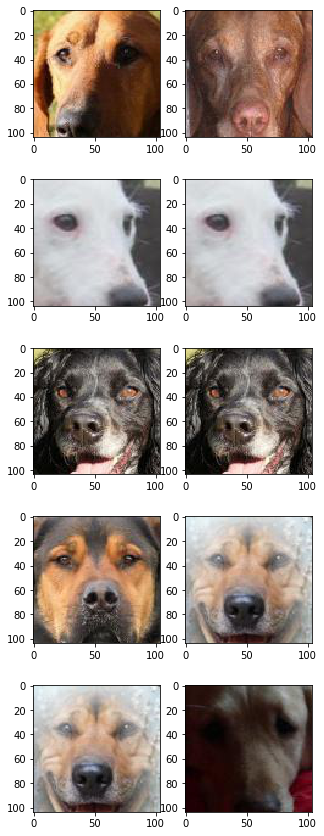

In [66]:
n = 5
s = 25
y_true = np.argmax(labels_valid, axis=1)
y_pred = np.argmax(pred, axis=1)
print(np.equal(y_true,y_pred)[s:5+s])
fig = plt.figure(figsize=(5,3*5))
for i in range(0,10,2):
    plt.subplot(5,2,i+1)
    plt.imshow(images_valid[i//2 + s]*0.5+0.5)
    plt.subplot(5,2,i+2)
    image_pred = images_valid[np.equal(y_true,np.argmax(pred[i//2 + s]))][0]
    plt.imshow(image_pred*0.5+0.5)

#### Evaluate on verification task

In [58]:
# Create pairs
h,w,c = SIZE
pairs = np.empty((len(images_test)*2,h,w,c))
issame = np.empty(len(images_test))
class_test = np.unique(labels_test)
for i in range(len(images_test)):
    alea = np.random.rand()
    # Pair of different dogs
    if alea < 0.5:
        # Chose the classes:
        class1 = np.random.randint(len(class_test))
        class2 = np.random.randint(len(class_test))
        while class1==class2:
            class2 = np.random.randint(len(class_test))
            
        # Extract images of this class:
        images_class1 = images_test[np.equal(labels_test,class1)]
        images_class2 = images_test[np.equal(labels_test,class2)]
        
        # Chose an image amoung these selected images
        pairs[i*2] = images_class1[np.random.randint(len(images_class1))]
        pairs[i*2+1] = images_class2[np.random.randint(len(images_class2))]
        issame[i] = 0
    # Pair of same dogs
    else:
        # Chose a class
        clas = np.random.randint(len(class_test))
        images_class = images_test[np.equal(labels_test,class1)]
        
        # Select two images from this class
        idx_image1 = np.random.randint(len(images_class))
        idx_image2 = np.random.randint(len(images_class))
        while idx_image1 == idx_image2:
            idx_image2 = np.random.randint(len(images_class))
        
        pairs[i*2] = images_class[idx_image1]
        pairs[i*2+1] = images_class[idx_image2]
        issame[i] = 1

[0. 1. 1. 1. 1.]


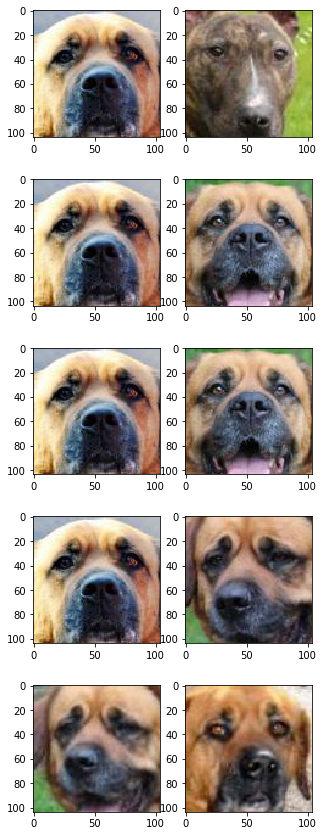

In [59]:
# Test: Check the pairs
s = 10
n = 5
print(issame[s:(n+s)])
fig = plt.figure(figsize=(5,3*n))
for i in range(s,s+n):
    plt.subplot(n,2,2*(i-s)+1)
    plt.imshow(pairs[2*i]*0.5+0.5)
    plt.subplot(n,2,2*(i-s)+2)
    plt.imshow(pairs[2*i+1]*0.5+0.5)

In [69]:
mod = tf.keras.Model(model.layers[0].input, model.layers[-2].output)
predict=mod.predict(pairs)
# Separates the pairs
emb1 = predict[0::2]
emb2 = predict[1::2]

# Computes distance between pairs
diff = np.square(emb1-emb2)
dist = np.sum(diff,1)

best = 0
best_t = 0
thresholds = np.arange(0.01,2,0.001)
for i in range(len(thresholds)):
    less = np.less(dist, thresholds[i])
    acc = np.logical_not(np.logical_xor(less, issame))
    acc = acc.astype(float)
    out = np.sum(acc)
    out = out/len(acc)
    if out > best:
        best_t = thresholds[i]
        best = out

print("Best threshold: " + str(best_t))
print("Best accuracy: " + str(best))

Best threshold: 0.7429999999999994
Best accuracy: 0.7692307692307693


### Observation on the heatmap

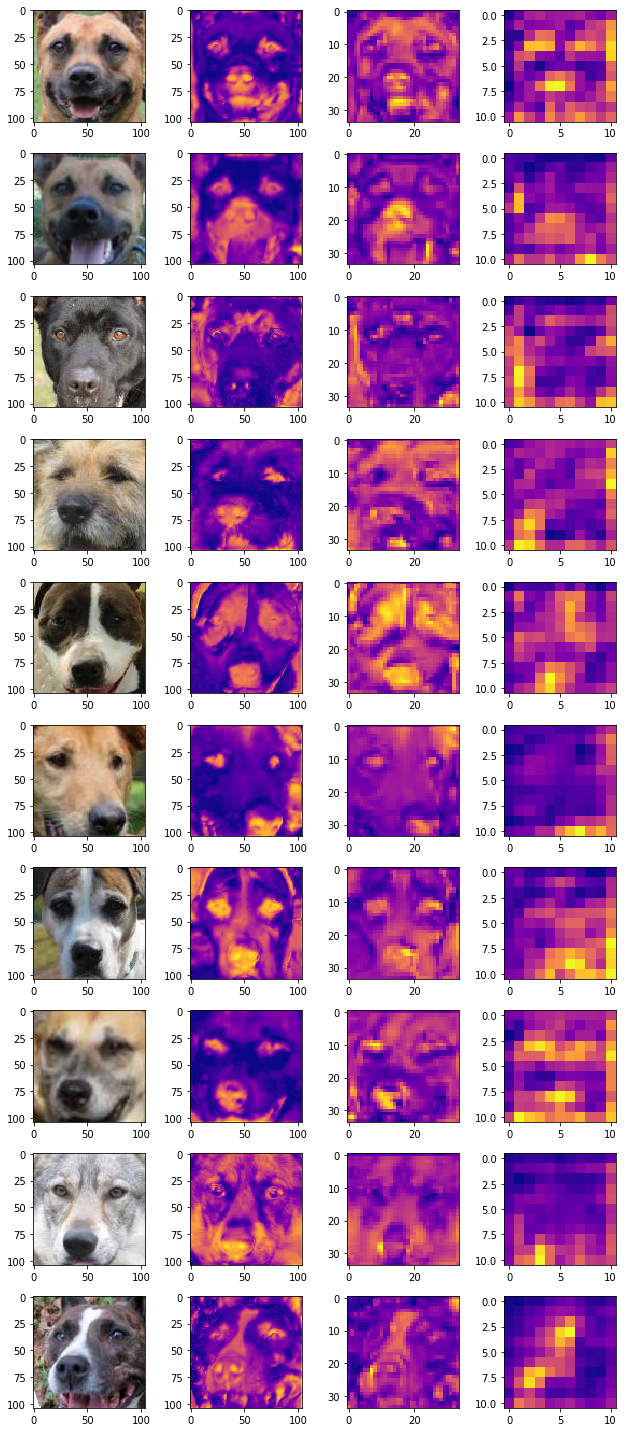

In [70]:
mod1 = tf.keras.Model(model.layers[0].input, model.layers[3].output)
predict1 = mod1.predict(images_train[0:100:10])

mod2 = tf.keras.Model(model.layers[0].input, model.layers[10].output)
predict2 = mod2.predict(images_train[0:100:10])

mod3 = tf.keras.Model(model.layers[0].input, model.layers[16].output)
predict3 = mod3.predict(images_train[0:100:10])

plt.figure(figsize=(9,20))
for i in range(10):
    pred1 = np.mean(predict1[i],axis=-1)
    pred2 = np.mean(predict2[i],axis=-1)
    pred3 = np.mean(predict3[i],axis=-1)

    
    plt.subplot(10,4,i*4+1)
    sk.io.imshow(images_train[i*10]*0.5+0.5)
    plt.subplot(10,4,i*4+2)
    plt.imshow(pred1,cmap='plasma')
    #sk.io.imshow(pred1)
    plt.subplot(10,4,i*4+3)
    plt.imshow(pred2,cmap='plasma')
    #sk.io.imshow(pred2)
    plt.subplot(10,4,i*4+4)
    plt.imshow(pred3,cmap='plasma')
    #sk.io.imshow(pred3)